# Training machine learning algorithm to detect showers

The goal of the method is to classify events into two categories - **shower**, **noise**

This procedure consists of the following parts:
1. [Data selection](#Data-selection)
    - Visible simulated events (simu signal above the background, track recognized in simulated shower signal).
    - Noisy simulated events (triggered well outside of track injection GTU). However, the background noise is from the flight data.
    - Flight noise events (triggered well outside of GTU 40).
    - Flight classified events - classified by the manual classification.
    
    
2. [Preparation of the testing and training datasets](#Preparation-of-the-testing-and-training-datasets)
    - Limitation: only subset of all extracted features is used to decrease computational demands of feature selection. However, the subset should be large enough to contain most of the features that are expected to have some property allowing to distinguish between a shower track and noise. This procedure should be selecting around 1000 event features from the database.
    - All visible simulated events should be included.
    - Datasets should be balanced (same size of each class).
    - Noise datased should be constructed by following priority: classified noise, unclassified flight, unclassified simu.
    
    
3. Conversion
    
    
4. Training
    
    
5. [Evaluation of the recognition efficiency](#Recognition-efficiency-RFECV-model)
    - Accuracy of classification on the whole dataset.
    - Accuracy (specificity) of classification on the labeled dataset of noise events.
    - Dependence of sensitivity to true energy, azimuth, and zenith angles.
    - Dependence of sensitivity to background intensity. *NOT DONE YET (TODO)*.

## Imports
(section not in the report)

In [138]:
import sys
import os
import subprocess
import re
import numpy as np
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as psql
import matplotlib as mpl
import hashlib
import time
import shutil

mpl.rcParams['figure.dpi'] = 80

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sp_opt

In [218]:
app_base_dir = '/home/spbproc/euso-spb-patt-reco-v1'
if app_base_dir not in sys.path:
    sys.path.append(app_base_dir)

import event_processing_v3
import event_processing_v4
import postgresql_v3_event_storage
import dataset_query_functions_v3

import tool.acqconv
from data_analysis_utils import *
from data_analysis_utils_dataframes import *
from data_analysis_utils_performance import * 
from utility_funtions import key_vals2val_keys

In [3]:
# import sklearn.preprocessing
# import sklearn.feature_selection
# import sklearn.ensemble 
# # import sklearn.neural_network
# import sklearn.discriminant_analysis
import sklearn.model_selection
import sklearn.metrics
# import sklearn.pipeline
# from sklearn.externals import joblib

## Directories

In [4]:
data_snippets_dir = 'ver4_machine_learning_convnet_szakcs_w_labeled_flight_20190628_2__v2'
source_data_snippets_dir = 'ver4_machine_learning_w_labeled_flight_20190628_2'
os.makedirs(data_snippets_dir, exist_ok=True)
os.makedirs(os.path.join(data_snippets_dir, 'figures'), exist_ok=True)

In [5]:
covnet_euso_base_dir = '/mnt/data_wdblue3d1/spbproc/convnet_euso'
covnet_euso_docker_dir = covnet_euso_base_dir
covnet_euso_dockerfile = os.path.join(covnet_euso_docker_dir, 'Dockerfile-gpu')
covnet_euso_src_dir = os.path.join(covnet_euso_base_dir, 'src')

## Data selection

In [6]:
event_processing_cls = event_processing_v4.EventProcessingV4
event_v3_storage_provider_simu = dataset_query_functions_v3.build_event_v3_storage_provider(
    event_storage_provider_config_file=os.path.join(app_base_dir,'config_simu_w_flatmap.ini'), 
    table_names_version='ver4',
    event_storage_class=postgresql_v3_event_storage.PostgreSqlEventV3StorageProvider,
    event_processing_class=event_processing_cls
)

query_functions_simu = dataset_query_functions_v3.Ver3DatasetQueryFunctions(event_v3_storage_provider_simu)

In [7]:
event_processing_cls = event_processing_v4.EventProcessingV4
event_v3_storage_provider_flight, config_w_flatmap_flight = dataset_query_functions_v3.build_event_v3_storage_provider(
    event_storage_provider_config_file=os.path.join(app_base_dir,'config_w_flatmap.ini'), 
    table_names_version='ver4',
    event_storage_class=postgresql_v3_event_storage.PostgreSqlEventV3StorageProvider,
    event_processing_class=event_processing_cls,
    return_global_config=True
)

query_functions_flight = dataset_query_functions_v3.Ver3DatasetQueryFunctions(event_v3_storage_provider_flight)

In [8]:
def load_inverse_means_frame_arr(config, calibration_map_path=None, ret_calibration_map_path=False, ret_arr=True):
    import process_acquisition_file
    
    if not calibration_map_path:
        if 'ProcessAcquisitionsParams' in config and 'calibration_map_path' in config['ProcessAcquisitionsParams']:
            calibration_map_path = config['ProcessAcquisitionsParams']['calibration_map_path']
        if 'FeatureExtractionParams' in config and 'calibration_map_path' in config['FeatureExtractionParams']:
            calibration_map_path = config['FeatureExtractionParams']['calibration_map_path']

    if calibration_map_path:
        inverse_means_frame_pathname, inverse_means_frame_arr = \
            process_acquisition_file.prepare_inverse_means_file(
                calibration_map_path, os.path.dirname(calibration_map_path),
                exist_ok=True, load_if_exists=True)
        if ret_calibration_map_path:
            if ret_arr:
                return calibration_map_path, inverse_means_frame_arr
            return calibration_map_path
        elif ret_arr:
            return inverse_means_frame_arr
    if ret_calibration_map_path and ret_arr:
        return None, None
    elif ret_calibration_map_path or ret_arr:
        return None

In [9]:
inverse_means_frame_arr = load_inverse_means_frame_arr(config_w_flatmap_flight)

### Selected columns

Unlinke machine learning approach, that would be trained directly on pixels and learn to identify important features as a part of a learning (for example convolutional neural network), this approach depends on a set of preselected features. Its possible advantage is that there is no need to discover identified features and after the feature extraction, the training is faster.

One of the sources of possible bias in the analysis might be initial selection of features that are analyzed by feature elimination methods.

For this experiment selected features include:
- number of triggered pixels (`trg_count_nonzero`),
- some properties describing the background frames and background frames projection,
- similarly for all frames of an event
- informations about line orientations in projections of a shower
- informations about precision of estimation the orientation of a shower
- ...

In [11]:
common_included_columns_re_list = [
    ('^$','source_file_(acquisition|trigger)(_full)?|global_gtu|packet_id|gtu_in_packet|event_id|num_gtu'),
    'trg_((gtu|x)_[yx])_hough_peak_thr1_major_line_phi', 
    ('orig_x_y','count_nonzero')
]

#### List of columns of simu data tables used for analysis

In [12]:
common_columns_for_analysis_dict = query_functions_simu.get_columns_for_classification_dict__by_excluding(
    excluded_columns_re_list=('^.+$',),
    default_excluded_columns_re_list=[],
    included_columns_re_list=common_included_columns_re_list
)

print_columns_dict(common_columns_for_analysis_dict)

spb_processing_v4_simu_flatmap.event
	- event_id
	- source_file_acquisition_full
	- source_file_trigger_full
	- source_file_acquisition
	- source_file_trigger
	- global_gtu
	- packet_id
	- gtu_in_packet
	- num_gtu

spb_processing_v4_simu_flatmap.event_orig_x_y
	- count_nonzero

spb_processing_v4_simu_flatmap.event_trg_x_y_hough_peak_thr1
	- major_line_phi

spb_processing_v4_simu_flatmap.event_trg_gtu_x_hough_peak_thr1
	- major_line_phi

spb_processing_v4_simu_flatmap.event_trg_gtu_y_hough_peak_thr1
	- major_line_phi

------------------------------------------------------------
13


In [13]:
common_df_columns = query_functions_simu.get_dataframe_columns_from_dict(common_columns_for_analysis_dict)

#### List of columns of flight data tables used for analysis

In [14]:
flight_columns_for_analysis_dict = query_functions_flight.get_columns_for_classification_dict__by_excluding(
    excluded_columns_re_list=('^.+$',),
    default_excluded_columns_re_list=[],
    included_columns_re_list=common_included_columns_re_list
)

# print_columns_dict(flight_columns_for_analysis_dict)

### Data selection queries

#### Simu visible events (base)

All positive samples for the training are simulated shower tracks with background from the flight data (see notebook ver4_flatmap_visible_events). Events considered as positive samples have to contain track signal (see ver4_test_selection_visualization__simu_signal notebook) and has to be considered as visible (see ver4_flatmap_simu_visible_events notebook). 

Visibility of the event is decided by a rule that **there should be at least two frames of the event which  contain a signal pixel that is greater or equal to maximum background intensity in the frame**.

Additionally there is rule that the first trigger of a visible event should be in GTU $42\pm10$.

In [15]:
# not in the report

current_columns_for_analysis_dict = common_columns_for_analysis_dict

common_select_clause_str, common_tables_list = \
    query_functions_simu.get_query_clauses__select(current_columns_for_analysis_dict)

simu_where_clauses_str, simu_tables_list = \
    query_functions_simu.get_query_clauses__where_simu(
        gtu_in_packet_distacne=(40, 10), 
        num_frames_signals_ge_bg__ge=2, num_frames_signals_ge_bg__le=999
    )

joined_select_clause_str = common_select_clause_str + ', ' + \
    ', '.join(['{{database_schema_name}}.simu_event.{}'.format(attr) for attr in [
        'simu2npy_pathname', 'edetector_numphotons', 'edetector_numcellhits', 'edetector_numfee', 'eptttrigger_fnumtrigg', 
        'etruth_trueenergy', 'etruth_truetheta', 'etruth_truephi', 'egeometry_pos_z',
        'etruth_trueshowermaxpos_x', 'etruth_trueshowermaxpos_y', 'etruth_trueshowermaxpos_z'
    ]]) + ', ' + \
    ', '.join(['{{database_schema_name}}.simu_event_additional.{}'.format(attr) for attr in [
        'num_frames_counts_gt_bg', 'num_frames_signals_gt_bg', 'num_frames_signals_ge_bg'
    ]])

joined_tables_list = common_tables_list + simu_tables_list + [
    ('{database_schema_name}.simu_event_relation','{data_table_name}','event_id'),
    ('{database_schema_name}.simu_event_additional','{database_schema_name}.simu_event_relation','relation_id'),
    ('{database_schema_name}.simu_event','{database_schema_name}.simu_event_relation','simu_event_id'),
]

join_clauses_str = \
    query_functions_simu.get_query_clauses__join(joined_tables_list)

source_data_type_num = 3001

simu_events_selection_query = query_functions_simu.get_events_selection_query_plain(
    source_data_type_num=source_data_type_num,
    select_additional=joined_select_clause_str, 
    join_additional=join_clauses_str,
    where_additional=simu_where_clauses_str,
    order_by='{data_table_name}.event_id', 
    offset=0, 
    limit=350000,
    base_select='')

# print(simu_events_selection_query)

In [16]:
simu_df = psql.read_sql(simu_events_selection_query, event_v3_storage_provider_simu.connection)

In [17]:
simu_df.head()

,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,orig_x_y_count_nonzero,...,etruth_trueenergy,etruth_truetheta,etruth_truephi,egeometry_pos_z,etruth_trueshowermaxpos_x,etruth_trueshowermaxpos_y,etruth_trueshowermaxpos_z,num_frames_counts_gt_bg,num_frames_signals_gt_bg,num_frames_signals_ge_bg
0,11464,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,169,1,41,11,2290,...,1.000000e+13,1.311530,2.02739,27000000.0,-174947.0,4109870.0,11689800.0,3.0,3.0,3.0
1,11465,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,163,1,35,24,2290,...,1.000000e+13,0.696797,4.65066,27000000.0,977005.0,1573110.0,4239100.0,16.0,16.0,16.0
2,11486,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,169,1,41,11,2290,...,1.000000e+13,1.311530,2.02739,27000000.0,-174947.0,4109870.0,11689800.0,2.0,2.0,2.0
3,11487,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,169,1,41,11,2290,...,1.000000e+13,1.311530,2.02739,27000000.0,-174947.0,4109870.0,11689800.0,3.0,3.0,3.0
4,11494,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,166,1,38,10,2289,...,1.000000e+13,0.941292,5.61160,27000000.0,-5503800.0,3748850.0,5879780.0,5.0,5.0,5.0


#### Simu noise events

Simu noise events are events that are caused by a trigger well outside of GTU of shower injection into a packet. 

It is not ideal to use these these events as samples of the dataset because due the way the background of these events is added to the signal. Simply, if there is less packets providing the background than simualated signal tracks then same event might be repeated multiple times in the dataset. 
Besides repetition of a background packet, background of the simualted event is created by repeating sequence of background frames, thus this might cause multiple events in a same packet. How often this situation happens has not been tested. It is not expected to be very typical.

Better method of constructing these events would help validity of this analysis.

In [18]:
# not in the report

current_columns_for_analysis_dict = common_columns_for_analysis_dict

common_select_clause_str, common_tables_list = \
    query_functions_simu.get_query_clauses__select(current_columns_for_analysis_dict)

# simu_noise_where_clauses_str = ' AND abs(gtu_in_packet-42) >= 20 '

# OPTIMIZATION, ROWS WITH NULL SHOULD BE ALSO ANALYZED  - noise simu df is not used
simu_noise_where_clauses_str = '''
    AND abs(gtu_in_packet-42) >= 20 
    AND {database_schema_name}.event_trg_gtu_y_hough_peak_thr1.major_line_phi IS NOT NULL 
    AND {database_schema_name}.event_trg_gtu_x_hough_peak_thr1.major_line_phi IS NOT NULL 
    AND {database_schema_name}.event_trg_x_y_hough_peak_thr1.major_line_phi IS NOT NULL
'''

joined_select_clause_str = common_select_clause_str + ', ' + \
    ', '.join(['{{database_schema_name}}.simu_event.{}'.format(attr) for attr in [
        'simu2npy_pathname', 'edetector_numphotons', 'edetector_numcellhits', 'edetector_numfee', 'eptttrigger_fnumtrigg', 
        'etruth_trueenergy', 'etruth_truetheta', 'etruth_truephi', 'egeometry_pos_z'
    ]]) + ', ' + \
    ', '.join(['{{database_schema_name}}.simu_event_additional.{}'.format(attr) for attr in [
        'num_frames_counts_gt_bg', 'num_frames_signals_gt_bg', 'num_frames_signals_ge_bg'
    ]])

joined_tables_list = common_tables_list + simu_tables_list + [
    ('{database_schema_name}.simu_event_relation','{data_table_name}','event_id'),
    ('{database_schema_name}.simu_event_additional','{database_schema_name}.simu_event_relation','relation_id'),
    ('{database_schema_name}.simu_event','{database_schema_name}.simu_event_relation','simu_event_id'),
]

join_clauses_str = \
    query_functions_simu.get_query_clauses__join(joined_tables_list)

source_data_type_num = 3001

noise_simu_events_selection_query = query_functions_simu.get_events_selection_query_plain(
    source_data_type_num=source_data_type_num,
    select_additional=joined_select_clause_str, 
    join_additional=join_clauses_str,
    where_additional=simu_noise_where_clauses_str,
    order_by='{data_table_name}.event_id', 
    offset=0, 
    limit=350000,
    base_select='')

# print(noise_simu_events_selection_query)

In [19]:
noise_simu_df = psql.read_sql(noise_simu_events_selection_query, event_v3_storage_provider_simu.connection)

In [20]:
noise_simu_df.head()

,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,orig_x_y_count_nonzero,...,edetector_numcellhits,edetector_numfee,eptttrigger_fnumtrigg,etruth_trueenergy,etruth_truetheta,etruth_truephi,egeometry_pos_z,num_frames_counts_gt_bg,num_frames_signals_gt_bg,num_frames_signals_ge_bg
0,11479,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,137,1,9,10,2290,...,0,22456,0,1.000000e+13,0.765393,2.473790,27000000.0,NaN,NaN,NaN
1,11500,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,201,1,73,10,2290,...,0,22456,0,1.000000e+13,0.765393,2.473790,27000000.0,NaN,NaN,NaN
2,11507,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,140,1,12,10,2290,...,0,19291,0,1.000000e+13,1.192790,0.311703,27000000.0,NaN,NaN,NaN
3,11516,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,233,1,105,10,2290,...,0,22456,0,1.000000e+13,0.765393,2.473790,27000000.0,NaN,NaN,NaN
4,11533,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,204,1,76,10,2290,...,0,19291,0,1.000000e+13,1.192790,0.311703,27000000.0,NaN,NaN,NaN


#### Flight improbable events

More preferred set of background noise events consists of events that triggered outside of expected range of GTU. Note that these events were triggered in a configuration with lowered thresholds (number selected bin is halved). However, using such events on its own is not sufficient because the actual flight events are those that were triggered in default configuration.

In [21]:
# not in the report
current_columns_for_analysis_dict = flight_columns_for_analysis_dict

unl_noise_flight_select_clause_str, unl_noise_flight_tables_list = \
    query_functions_flight.get_query_clauses__select(current_columns_for_analysis_dict)

unl_noise_flight_clauses_str = \
    query_functions_flight.get_query_clauses__join(unl_noise_flight_tables_list)

unl_noise_source_data_type_num = 1

unl_noise_flight_where_clauses_str = ''' 
    AND abs(gtu_in_packet-42) > 20
    AND {database_schema_name}.event_orig_x_y.count_nonzero > 256*6
''' 

# intentionally removed
#     AND {database_schema_name}.event_trg_gtu_y_hough_peak_thr1.major_line_phi IS NOT NULL 
#     AND {database_schema_name}.event_trg_gtu_x_hough_peak_thr2.major_line_phi IS NOT NULL 
#     AND {database_schema_name}.event_trg_x_y_hough_peak_thr1.major_line_phi IS NOT NULL

unl_noise_flight_events_selection_query = \
    query_functions_flight.get_events_selection_query_plain(
        source_data_type_num=unl_noise_source_data_type_num,
        select_additional=unl_noise_flight_select_clause_str, 
        join_additional=unl_noise_flight_clauses_str,
        where_additional=unl_noise_flight_where_clauses_str,
        order_by='{data_table_name}.event_id', 
        offset=0, 
        limit=80000,                            # intentionally selecting incomplete subset to save memory !!!!!!!!!!!!!
    #     limit=350000,
        base_select='')

# print(unl_noise_flight_events_selection_query)

In [22]:
all_unl_noise_flight_df = psql.read_sql(unl_noise_flight_events_selection_query, event_v3_storage_provider_flight.connection)
# flight_df = psql.read_sql(flight_events_selection_query, event_v3_storage_provider_flight.connection)

In [23]:
all_unl_noise_flight_df.head()

,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,orig_x_y_count_nonzero,trg_x_y_hough_peak_thr1_major_line_phi,trg_gtu_x_hough_peak_thr1_major_line_phi,trg_gtu_y_hough_peak_thr1_major_line_phi
0,63,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055842...,trn_20170429-055842-001.001_C_inverse_flat_ave...,94,0,94,12,2048,5.818010,2.471490,2.41973
1,65,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055842...,trn_20170429-055842-001.001_C_inverse_flat_ave...,131,1,3,12,2042,1.580130,0.098652,2.57798
2,70,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055842...,trn_20170429-055842-001.001_C_inverse_flat_ave...,226,1,98,10,2039,NaN,1.407700,1.58790
3,84,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170503-085415...,trn_20170503-085415-001.001_C_inverse_flat_ave...,12,0,12,9,2290,NaN,NaN,NaN
4,94,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055842...,trn_20170429-055842-001.001_C_inverse_flat_ave...,479,3,95,10,2039,0.013996,1.329610,3.02945


In [24]:
len(all_unl_noise_flight_df)

56229

In [25]:
# intentional !!!
unl_noise_flight_df = all_unl_noise_flight_df

#### Flight labeled events

Important part of the dataset is set of events that were triggered by the hardware. These events are expected to be the hardest to recognize. Previous classification experiments without this set of events significantly limited usefulness of the method because it classified 60% of the flight events sample as a track (see ver4_test_selection_visualization__simu_20181018 notebook).
Addition of a relatively small set of these events (around 1500) seems to help significantly (see ver4_machine_learning_flight_classification_tsne_cfg3 notebook).

The manually classified dataset has been created using web classification tool (script web_manual_classification.py). The tool is available at http://eusospb-data.michalvrabel.sk.

In [26]:

EVENT_CLASSES = {
    'pixel': 2,
    'top_left_ec': 5,
    'blob': 12,
    'large_blob': 11,
    'short_single_gtu_track': 7,
    'single_gtu_track': 3,
    'noise': 1,
    'cartesian_line': 4,
    'strong_pmt_edge': 9,
    'few_pixels': 6,
    'bg_increased_suddenly': 10,
    'persistent_pixel': 14,
    'noise_unspecified': 0,
    'unspecified': 8,
    'shower': 13,
    '2pix_line': 15,
    'bright_blob': 16,
    'blob_and_pixels': 17,
    'pixel_w_blob_behind': 18,
    'storng_light': 19,
    'sparse_blobs': 20,
    'noise_with_weak_pixel': 21,
    #
    'unclassified': -1
}

INVERSE_EVENT_CLASSES = {v: k for k, v in EVENT_CLASSES.items()}

EVENT_CLASS_NUMBER_UNLABELED = -1
EVENT_CLASS_NUMBER_UNLABELED_NOISE = -2
EVENT_CLASS_LABLELED_NOISE_FLIGHT = -3  # in case of reduced classification

classification_table_name = event_v3_storage_provider_flight.database_schema_name + '.event_manual_classification'
classification_table_cls_column_name_simple = 'class_number'
classification_table_note_column_name_simple = 'note'
classification_table_last_modification_column_name_simple = 'last_modification'
classification_table_cls_column_name = classification_table_name + '.' + classification_table_cls_column_name_simple
classification_table_note_column_name = classification_table_name + '.' + classification_table_note_column_name_simple
classification_table_last_modification_column_name = classification_table_name + '.' + classification_table_last_modification_column_name_simple
classification_df_cls_column_name ='manual_classification_' + classification_table_cls_column_name_simple
classification_df_note_column_name ='manual_classification_' + classification_table_note_column_name_simple

##### Labeled filght noise In the database

In [27]:
# not in the report
current_columns_for_analysis_dict = flight_columns_for_analysis_dict

lbl_noise_flight_select_clause_str, lbl_noise_flight_tables_list = \
    query_functions_flight.get_query_clauses__select({
        **current_columns_for_analysis_dict,
        classification_table_name: [classification_table_cls_column_name_simple]
    })

lbl_noise_flight_clauses_str = query_functions_flight.get_query_clauses__join(lbl_noise_flight_tables_list)

lbl_noise_source_data_type_num = 1

lbl_noise_flight_where_clauses_str = ''' 
    AND abs(gtu_in_packet-42) <= 20
    AND {{database_schema_name}}.event_orig_x_y.count_nonzero > 256*6
    AND {classification_table_cls_column_name} NOT IN ({event_class_shower}, {event_class_unspecified})
    
'''.format(
    classification_table_cls_column_name=classification_table_cls_column_name,
    classification_table_last_modification_column_name=classification_table_last_modification_column_name,
    event_class_shower=EVENT_CLASSES['shower'],
    event_class_unspecified=EVENT_CLASSES['unspecified']
)

# intentionally removed

# AND {{database_schema_name}}.event_trg_gtu_y_hough_peak_thr1.major_line_phi IS NOT NULL 
# AND {{database_schema_name}}.event_trg_gtu_x_hough_peak_thr2.major_line_phi IS NOT NULL 
# AND {{database_schema_name}}.event_trg_x_y_hough_peak_thr1.major_line_phi IS NOT NULL
# AND {classification_table_last_modification_column_name} < '2019-04-09'

lbl_noise_flight_events_selection_query = \
    query_functions_flight.get_events_selection_query_plain(
        source_data_type_num=lbl_noise_source_data_type_num,
        select_additional=lbl_noise_flight_select_clause_str, 
        join_additional=lbl_noise_flight_clauses_str,
        where_additional=lbl_noise_flight_where_clauses_str,
        order_by='{data_table_name}.event_id', 
        offset=0, 
        limit=10000,                            # intentionally selecting incomplete subset to save memory !!!!!!!!!!!!!
    #     limit=350000,
        base_select='')

# print(lbl_noise_flight_events_selection_query)

In [28]:
lbl_noise_flight_db_df = psql.read_sql(lbl_noise_flight_events_selection_query, event_v3_storage_provider_flight.connection)
# lbl_noise_flight_df[classification_df_cls_column_name] 

In [29]:
len(lbl_noise_flight_db_df)

4783

In [30]:
for k, v in lbl_noise_flight_db_df.groupby(classification_df_cls_column_name).count()['event_id'].items():
    print('{:<30}\t{:d}'.format(INVERSE_EVENT_CLASSES[k], v))

noise_unspecified             	225
noise                         	406
pixel                         	767
single_gtu_track              	218
cartesian_line                	77
top_left_ec                   	494
few_pixels                    	256
short_single_gtu_track        	188
bg_increased_suddenly         	478
large_blob                    	199
blob                          	424
persistent_pixel              	135
2pix_line                     	98
bright_blob                   	141
blob_and_pixels               	36
pixel_w_blob_behind           	434
storng_light                  	18
sparse_blobs                  	62
noise_with_weak_pixel         	127


In [31]:
lbl_noise_flight_db_df.head()

,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,orig_x_y_count_nonzero,trg_x_y_hough_peak_thr1_major_line_phi,trg_gtu_x_hough_peak_thr1_major_line_phi,trg_gtu_y_hough_peak_thr1_major_line_phi,manual_classification_class_number
0,75,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170501-050224...,trn_20170501-050224-001.001_C_inverse_flat_ave...,162,1,34,15,2290,2.50343,6.283010,6.28298,0
1,87,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170502-061155...,trn_20170502-061155-001.001_C_inverse_flat_ave...,168,1,40,92,2304,0.43432,0.018703,6.25235,19
2,95,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170501-050224...,trn_20170501-050224-001.001_C_inverse_flat_ave...,551,4,39,10,2290,1.53181,0.702623,1.41792,15
3,100,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055842...,trn_20170429-055842-001.001_C_inverse_flat_ave...,536,4,24,12,2043,0.06070,6.277520,1.43817,1
4,134,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170504-113024...,trn_20170504-113024-001.001_C_inverse_flat_ave...,550,4,38,13,2290,1.37296,2.788830,1.56580,2


##### Labeled flight noise in the file

In [32]:
lbl_noise_flight_df = pd.read_csv(os.path.join(source_data_snippets_dir, 'events/labeled_flight_noise.tsv.gz'), sep='\t')

In [33]:
len(lbl_noise_flight_df)

2619

In [34]:
for k, v in lbl_noise_flight_df.groupby(classification_df_cls_column_name).count()['event_id'].items():
    print('{:<30}\t{:d}'.format(INVERSE_EVENT_CLASSES[k], v))

noise_unspecified             	42
noise                         	255
pixel                         	532
single_gtu_track              	111
cartesian_line                	30
top_left_ec                   	355
few_pixels                    	162
short_single_gtu_track        	79
bg_increased_suddenly         	196
large_blob                    	145
blob                          	301
persistent_pixel              	34
2pix_line                     	29
bright_blob                   	90
blob_and_pixels               	24
pixel_w_blob_behind           	147
storng_light                  	5
sparse_blobs                  	19
noise_with_weak_pixel         	63


In [35]:
lbl_noise_flight_df.head()

,Unnamed: 0,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,...,proc3_gtu_y_hough_peak_thr3_major_line_phi_diff_pi_over_2,proc3_gtu_x_hough_peak_thr3_major_line_phi_diff_0,proc3_gtu_x_hough_peak_thr3_major_line_phi_diff_pi_over_2,norm_proc1_x_y_hough_peak_thr2_line_clusters_count,norm_proc1_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width,norm_proc1_gtu_y_hough_peak_thr2_line_clusters_max_peak_clu_width,norm_proc1_gtu_x_hough_peak_thr2_line_clusters_max_peak_clu_width,norm_trg_count_nonzero,norm_num_gtu,rank
0,0,75,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170501-050224...,trn_20170501-050224-001.001_C_inverse_flat_ave...,162,1,34,15,...,1.568001,0.000028,1.570768,0.833333,0.972067,0.971591,0.977654,0.020705,0.148515,324.316832
1,1,95,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170501-050224...,trn_20170501-050224-001.001_C_inverse_flat_ave...,551,4,39,10,...,0.079414,1.194000,0.376796,0.750000,0.910615,0.920455,0.893855,0.000102,0.099010,324.316832
2,2,134,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170504-113024...,trn_20170504-113024-001.001_C_inverse_flat_ave...,550,4,38,13,...,0.212524,1.548263,0.022534,0.750000,0.826816,0.892045,0.910615,0.000327,0.128713,324.316832
3,3,322,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170505-100211...,trn_20170505-100211-001.001_C_inverse_flat_ave...,547,4,35,10,...,1.561131,0.007136,1.563660,0.833333,0.944134,0.948864,0.921788,0.000246,0.099010,324.316832
4,4,520,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170505-100211...,trn_20170505-100211-001.001_C_inverse_flat_ave...,1576,12,40,10,...,1.495681,0.210610,1.360186,0.583333,0.899441,0.926136,0.916201,0.000430,0.099010,324.316832


#### Flight unclassified probable events

Small subset of flight unclassified events, that were caused by trigger around GTU 42, are selected to be used for basic check of the data reduction capability.

In [36]:
# not in the report
current_columns_for_analysis_dict = flight_columns_for_analysis_dict

unl_flight_select_clause_str, unl_flight_tables_list = \
    query_functions_flight.get_query_clauses__select(current_columns_for_analysis_dict)

unl_flight_clauses_str = \
    query_functions_flight.get_query_clauses__join(unl_flight_tables_list)

unl_flight_source_data_type_num = 1
# intentionally keeping trg conditions, for consistency
unl_flight_where_clauses_str = ''' 
    AND abs(gtu_in_packet-42) < 20
    AND {{database_schema_name}}.event_trg_gtu_y_hough_peak_thr1.major_line_phi IS NOT NULL 
    AND {{database_schema_name}}.event_trg_gtu_x_hough_peak_thr1.major_line_phi IS NOT NULL 
    AND {{database_schema_name}}.event_trg_x_y_hough_peak_thr1.major_line_phi IS NOT NULL
    AND {{database_schema_name}}.event_orig_x_y.count_nonzero > 256*6
    AND NOT EXISTS(
        SELECT {classification_table}.{{data_table_pk}} 
        FROM {classification_table} 
        WHERE {classification_table}.{{data_table_pk}} = {{data_table_name}}.{{data_table_pk}} LIMIT 1
    )
'''.format(
    classification_table=classification_table_name,
)

unl_flight_events_selection_query = query_functions_flight.get_events_selection_query_plain(
    source_data_type_num=unl_flight_source_data_type_num,
    select_additional=unl_flight_select_clause_str, 
    join_additional=unl_flight_clauses_str,
    where_additional=unl_flight_where_clauses_str,
    order_by='{data_table_name}.event_id',  # 'RANDOM()', # it might be skewed
    offset=0, 
    limit=10000,                            # intentionally selecting incomplete subset to save memory !!!!!!!!!!!!!
#     limit=350000,
    base_select='')

# print(unl_flight_events_selection_query)

In [37]:
unl_flight_df = psql.read_sql(unl_flight_events_selection_query, event_v3_storage_provider_flight.connection)

In [38]:
unl_flight_df.head()

,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,orig_x_y_count_nonzero,trg_x_y_hough_peak_thr1_major_line_phi,trg_gtu_x_hough_peak_thr1_major_line_phi,trg_gtu_y_hough_peak_thr1_major_line_phi
0,61,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055842...,trn_20170429-055842-001.001_C_inverse_flat_ave...,39,0,39,11,2045,0.433973,0.629839,2.798010
1,67,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055842...,trn_20170429-055842-001.001_C_inverse_flat_ave...,166,1,38,11,2041,0.140550,0.029569,2.507860
2,73,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170501-050224...,trn_20170501-050224-001.001_C_inverse_flat_ave...,39,0,39,22,2290,5.521390,2.409180,0.313222
3,77,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170430-072445...,trn_20170430-072445-001.001_C_inverse_flat_ave...,38,0,38,33,2290,5.914780,0.000931,6.276950
4,78,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055842...,trn_20170429-055842-001.001_C_inverse_flat_ave...,296,2,40,13,2056,2.401640,6.274460,6.281470


#### Classification column for unlabeled filght
(not in the report)

In [39]:
unl_flight_df[classification_df_cls_column_name] = EVENT_CLASS_NUMBER_UNLABELED
unl_noise_flight_df[classification_df_cls_column_name] = EVENT_CLASS_NUMBER_UNLABELED_NOISE

### Flight datasets in dict
(not in the report)

In [40]:
flight_df_dict = {
    'unl_noise_flight_df': unl_noise_flight_df, 
    'lbl_noise_flight_df': lbl_noise_flight_df, 
    'unl_flight_df': unl_flight_df
}

### Closing connections
(not in the report)

In [41]:
event_v3_storage_provider_simu.connection.close()
event_v3_storage_provider_flight.connection.close()

### Combined simulations dataset

Simu dataframes are combined because they have same columns. 
Then within this dataset events are classified into four groups based on 
- **Query classification information** - Primary classification based on the original data selection query - original intention of the data selection.
- **Simu signal classification information** - Secondary classification is addition of labeled simu signal events. The events are loaded from tables prepared in ver4_test_selection_visualization__simu_signal notebook.

The groups are the following:
- **simu noise** - data selected by query intended to select visible events but simu signal is classified as noisy simu data
- **simu track** - data selected by query intended to select visible events and simu signal is classified as a signal - <br> *these events will be used as positive samples for machine learning algorithms*
- **noise track** - data selected by query intended to select noise events but simu signal is classified as a shower
- **noise noise** - data selected by query intended to select noise events and contains simu signal classified as noisy simu data (could be used as a part of negative samples dataset, although it is not ideal)
- **simu unclassified**, **noise unclassified** - data without any labelling for simu signal data, generaly should consist of short tracks or noisy tracks, in-between easily recognizable tracks and noise.
- **simu noise underflow**, **simu noise overflow**, **simu track underflow**, **simu track overflow** - data selected by query intended to select visible events but no simu signal is present (ideally should be empty)
- **noise noise underflow**, **noise noise overflow**, **noise track underflow**, **noise track overflow**   - data selected by query intended to select noise events and no simu signal is present - <br> *these events will be used as negative samples but with a low priority*

In [42]:
combined_simu_df = pd.concat([simu_df, noise_simu_df])

In [43]:
# flight_columns_list = list(lbl_noise_flight_df.columns.values)
# combined_flight_df = pd.concat([unl_noise_flight_df[flight_columns_list], lbl_noise_flight_df[flight_columns_list], unl_flight_df[flight_columns_list]])

In [44]:
print('len(simu_df) =', len(simu_df))
print('len(noise_simu_df) =', len(noise_simu_df))
print('len(combined_simu_df) =', len(combined_simu_df))

len(simu_df) = 35607
len(noise_simu_df) = 128793
len(combined_simu_df) = 164400


#### $R_{max}$ property of simulated showers

In [45]:
# 'etruth_trueshowermaxpos_x', 'etruth_trueshowermaxpos_y', 'etruth_trueshowermaxpos_z'
combined_simu_df['calc_etruth_trueshower_rmax'] = np.hypot(combined_simu_df['etruth_trueshowermaxpos_x'], combined_simu_df['etruth_trueshowermaxpos_y'])

#### Query classification information
Primary classification based on the original data selection query - original intention of the data selection.

In [46]:
combined_simu_df['cond_selection_query'] = 'undefined'
combined_simu_df.loc[combined_simu_df['event_id'].isin(simu_df['event_id']), 'cond_selection_query'] = 'simu'
combined_simu_df.loc[combined_simu_df['event_id'].isin(noise_simu_df['event_id']), 'cond_selection_query'] = 'noise'

In [47]:
if('simu_df' in locals()): del simu_df
if('noise_simu_df' in locals()): del noise_simu_df
# if('unl_noise_flight_df' in locals()): del unl_noise_flight_df
# if('lbl_noise_flight_df' in locals()): del lbl_noise_flight_df
# if('unl_flight_df' in locals()): del unl_flight_df

#### Simu signal classification information
Secondary classification is addition of labeled simu signal events.
The events are loaded from tables prepared in ver4_test_selection_visualization__simu_signal notebook.

In [48]:
# [['event_id', 'source_file_acquisition', 'global_gtu', 'packet_id', 'gtu_in_packet', 'num_gtu', 'source_file_acquisition_full']]

simu_signal_data_snippets_dir = 'ver4_simu_signal_data_snippets'
simu_signal_visible_tracks_table_path = os.path.join(simu_signal_data_snippets_dir, 'visible_tracks_table.tsv')
simu_signal_noisy_events_table_path = os.path.join(simu_signal_data_snippets_dir, 'noisy_events_table.tsv')

combined_simu_df, unclassified_simu_df, \
track_simu_df, track_underflow_simu_df, track_overflow_simu_df, \
noise_simu_df, noise_underflow_simu_df, noise_overflow_simu_df, \
simu_signal_track_events_df, simu_signal_noisy_events_df = \
    add_classification_columns(
        combined_simu_df, 
        simu_signal_visible_tracks_table_path, simu_signal_noisy_events_table_path,
        ret_simu_signal=True, ret_under_over_track=True, ret_split_noise=True,
        simu_track_class='track', simu_noise_class='noise',
        simu_track_underflow_class='track_underflow', simu_track_overflow_class='track_overflow',
        simu_noise_underflow_class='noise_underflow', simu_noise_overflow_class='noise_overflow',
        simu_events_file_pathname_dir=data_snippets_dir)

##### Combined label - joining query and labeled simu class

In [49]:
combined_simu_df['cond_selection_combined'] = 'undefined'

for selection_query in ['simu','noise']:
    for selection_simu_signal in ['noise','track']:
        for simu_signal_sync in ['', 'underflow', 'overflow']:
            t_selection_simu_signal = selection_simu_signal
            if len(simu_signal_sync) > 0:
                t_selection_simu_signal += '_' + simu_signal_sync
            combined_simu_df.loc[
                (combined_simu_df['cond_selection_query'] == selection_query ) & 
                (combined_simu_df['cond_selection_simple'] == t_selection_simu_signal), 
                'cond_selection_combined'] = selection_query + '_' + t_selection_simu_signal

##### Size of the  subsets

###### Simu signal labels

In [50]:
print('len(simu_signal_track_events_df)', len(simu_signal_track_events_df))
print('len(simu_signal_noisy_events_df)', len(simu_signal_noisy_events_df))
print('-'*50)
print('len(combined_simu_df)           ', len(combined_simu_df))
print('-'*50)
print('len(unclassified_simu_df)       ', len(unclassified_simu_df))
print('len(track_simu_df)              ', len(track_simu_df))
print('len(track_underflow_simu_df)    ', len(track_underflow_simu_df))
print('len(track_overflow_simu_df)     ', len(track_overflow_simu_df))
print('len(noise_simu_df)              ', len(noise_simu_df))
print('len(noise_underflow_simu_df)    ', len(noise_underflow_simu_df))
print('len(noise_overflow_simu_df)     ', len(noise_overflow_simu_df))
print('-'*50)
print('                                   ', 
      len(unclassified_simu_df) + \
      len(track_simu_df) + len(track_underflow_simu_df) + len(track_overflow_simu_df) + \
      len(noise_simu_df) + len(noise_underflow_simu_df) + len(noise_overflow_simu_df)
     )
print('-'*50)
print('len(track_simu_df)/len(combined_simu_df)        = ', len(track_simu_df)/len(combined_simu_df))
print('len(unclassified_simu_df)/len(combined_simu_df) = ', len(unclassified_simu_df)/len(combined_simu_df))
print('len(noise_simu_df)/len(combined_simu_df)        = ', len(noise_simu_df)/len(combined_simu_df))

len(simu_signal_track_events_df) 14866
len(simu_signal_noisy_events_df) 59279
--------------------------------------------------
len(combined_simu_df)            164400
--------------------------------------------------
len(unclassified_simu_df)        9288
len(track_simu_df)               35038
len(track_underflow_simu_df)     5983
len(track_overflow_simu_df)      16956
len(noise_simu_df)               1608
len(noise_underflow_simu_df)     24689
len(noise_overflow_simu_df)      70838
--------------------------------------------------
                                    164400
--------------------------------------------------
len(track_simu_df)/len(combined_simu_df)        =  0.2131265206812652
len(unclassified_simu_df)/len(combined_simu_df) =  0.056496350364963505
len(noise_simu_df)/len(combined_simu_df)        =  0.00978102189781022


###### Selection query and simu signal labels

In [51]:
for selection_query in ['simu','noise']:
    for selection_simu_signal in ['noise','track']:
        for simu_signal_sync in ['', 'underflow', 'overflow']:
            t_selection_simu_signal = selection_simu_signal
            if len(simu_signal_sync) > 0:
                t_selection_simu_signal += '_' + simu_signal_sync
            print('{:<30} {}'.format(
                '{} - {}'.format(selection_query, t_selection_simu_signal),
                np.count_nonzero(
                    (combined_simu_df['cond_selection_query'] == selection_query ) & \
                    (combined_simu_df['cond_selection_simple'] == t_selection_simu_signal))
            ))                

simu - noise                   4
simu - noise_underflow         0
simu - noise_overflow          0
simu - track                   34521
simu - track_underflow         0
simu - track_overflow          0
noise - noise                  1604
noise - noise_underflow        24689
noise - noise_overflow         70838
noise - track                  517
noise - track_underflow        5983
noise - track_overflow         16956


##### Example of track underflow subset

In [52]:
track_underflow_simu_df.sort_values('gtu_in_packet', ascending=False).head()

,edetector_numcellhits,edetector_numfee,edetector_numphotons,egeometry_pos_z,eptttrigger_fnumtrigg,etruth_trueenergy,etruth_truephi,etruth_trueshowermaxpos_x,etruth_trueshowermaxpos_y,etruth_trueshowermaxpos_z,...,source_file_trigger,source_file_trigger_full,trg_gtu_x_hough_peak_thr1_major_line_phi,trg_gtu_y_hough_peak_thr1_major_line_phi,trg_x_y_hough_peak_thr1_major_line_phi,calc_etruth_trueshower_rmax,cond_selection_query,simu2npy_signals_pathname,simu2npy_signals_pathname_short,cond_selection_simple
45187,0,27651,9512,21000000.0,1,1.412540e+12,5.167210,NaN,NaN,NaN,...,posz_21000000.00/energy_1.41e+12/thousnd21E3.2...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,2.087140,0.182200,0.162611,NaN,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_21000000.00/energy_1.41e+12/thousnd21E3.2...,track_underflow
25116,0,39476,100445,24000000.0,1,5.950000e+12,0.066001,NaN,NaN,NaN,...,posz_24000000.00/energy_5.95e+12/simu.2017-07-...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,0.014447,2.365370,1.556460,NaN,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_24000000.00/energy_5.95e+12/simu.2017-07-...,track_underflow
21799,0,38729,60454,24000000.0,0,5.950000e+12,4.709430,NaN,NaN,NaN,...,posz_24000000.00/energy_5.95e+12/simu.2017-07-...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,6.273740,6.270100,0.747655,NaN,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_24000000.00/energy_5.95e+12/simu.2017-07-...,track_underflow
3711,0,25774,7124,27000000.0,0,1.258930e+12,2.466220,NaN,NaN,NaN,...,posz_27000000.00/energy_1.26e+12/thousnd27E2/l...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,6.277200,6.199100,0.001819,NaN,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_27000000.00/energy_1.26e+12/thousnd27E2/s...,track_underflow
93171,0,20371,42824,18000000.0,1,5.250000e+12,3.613280,NaN,NaN,NaN,...,posz_18000000.00/energy_5.25e+12/simu.2017-07-...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,0.384665,0.477307,6.112560,NaN,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_18000000.00/energy_5.25e+12/simu.2017-07-...,track_underflow


##### Example of track overflow subset

In [53]:
track_overflow_simu_df.sort_values('gtu_in_packet', ascending=True).head()

,edetector_numcellhits,edetector_numfee,edetector_numphotons,egeometry_pos_z,eptttrigger_fnumtrigg,etruth_trueenergy,etruth_truephi,etruth_trueshowermaxpos_x,etruth_trueshowermaxpos_y,etruth_trueshowermaxpos_z,...,source_file_trigger,source_file_trigger_full,trg_gtu_x_hough_peak_thr1_major_line_phi,trg_gtu_y_hough_peak_thr1_major_line_phi,trg_x_y_hough_peak_thr1_major_line_phi,calc_etruth_trueshower_rmax,cond_selection_query,simu2npy_signals_pathname,simu2npy_signals_pathname_short,cond_selection_simple
53058,0,21225,13409,30000000.0,0,1.995260e+12,6.275790,NaN,NaN,NaN,...,posz_30000000.00/energy_2.00e+12/thousnd30E6.2...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,1.470330,1.51624,0.060410,NaN,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_30000000.00/energy_2.00e+12/thousnd30E6.2...,track_overflow
58199,0,29155,11260,30000000.0,0,1.584890e+12,1.471500,NaN,NaN,NaN,...,posz_30000000.00/energy_1.58e+12/thousnd30E4.2...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,0.700929,1.48516,6.257140,NaN,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_30000000.00/energy_1.58e+12/thousnd30E4.2...,track_overflow
58697,0,25726,9003,30000000.0,0,1.584890e+12,0.401451,NaN,NaN,NaN,...,posz_30000000.00/energy_1.58e+12/thousnd30E4.2...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,0.010381,6.17482,0.116087,NaN,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_30000000.00/energy_1.58e+12/thousnd30E4.2...,track_overflow
59486,0,21687,151669,21000000.0,1,3.940000e+12,1.387970,NaN,NaN,NaN,...,posz_21000000.00/energy_3.94e+12/ter212.2017-0...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,0.753375,0.77655,0.770847,NaN,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_21000000.00/energy_3.94e+12/ter212.2017-0...,track_overflow
110238,0,30181,146123,18000000.0,1,8.500000e+12,5.381020,NaN,NaN,NaN,...,posz_18000000.00/energy_8.50e+12/set18.2017-07...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,0.010381,6.17482,0.116087,NaN,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_18000000.00/energy_8.50e+12/set18.2017-07...,track_overflow


##### Visualization of a few events

- Noise entries are sorted by number of simu signal pixles in x-y projection in descending order (`orig_x_y_count_nonzero`, sorted from the most potentially track-like),
- Track entries are sorted by num frames where maximum signal is greater equal maximum background in acsending order (`num_frames_signals_ge_bg`, from the least visible track events). Non-track-like simu signal might not be necessarly incorrectly labeled entries, just a small portion of a track in signal.
- Track underflow, track overflow should all contain empty simu signal data. Entries are sorted by GTU in packet in ascending or descending order, respectively.

noise (1608 entries)
--------------------------------------------------
#0	(0)
	event_id: 2261798
	packet_id: 1
	gtu_in_packet: 17
	num_gtu: 23
	num_frames_signals_ge_bg: 0.0
	simu2npy_signals_pathname_short: posz_30000000.00/energy_6.31e+12/thousnd30E16.2017-07-25-13h05m21s/simu2npy/ev_34_mc_1__signals.npy
	cond_selection_query: noise
	cond_selection_simple: noise


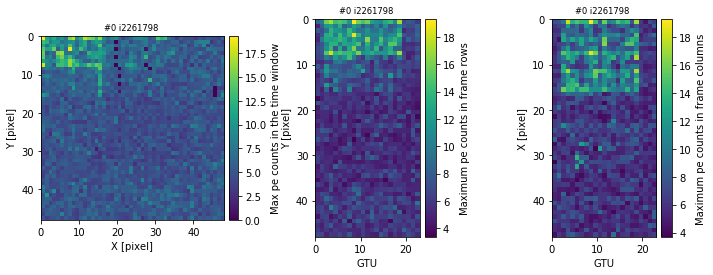

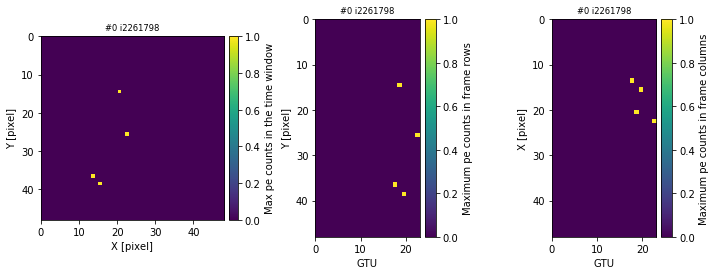

#1	(0)
	event_id: 2020798
	packet_id: 1
	gtu_in_packet: 17
	num_gtu: 23
	num_frames_signals_ge_bg: 0.0
	simu2npy_signals_pathname_short: posz_18000000.00/energy_5.62e+12/thousnd18E15.2017-07-28-11h19m08s/simu2npy/ev_77_mc_1__signals.npy
	cond_selection_query: noise
	cond_selection_simple: noise


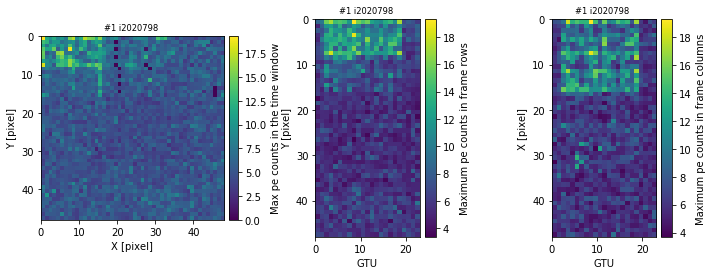

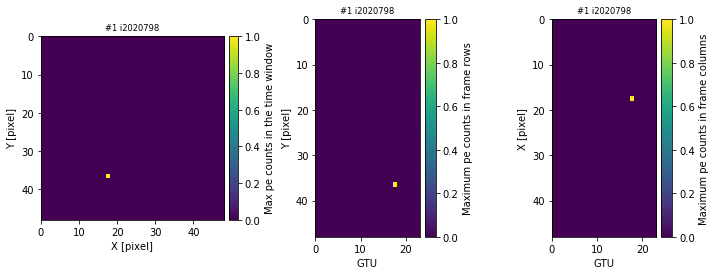

#2	(0)
	event_id: 2452180
	packet_id: 1
	gtu_in_packet: 21
	num_gtu: 20
	num_frames_signals_ge_bg: 0.0
	simu2npy_signals_pathname_short: posz_18000000.00/energy_7.15e+12/simu.2017-07-24-06h44m34s/simu2npy/ev_50_mc_1__signals.npy
	cond_selection_query: noise
	cond_selection_simple: noise


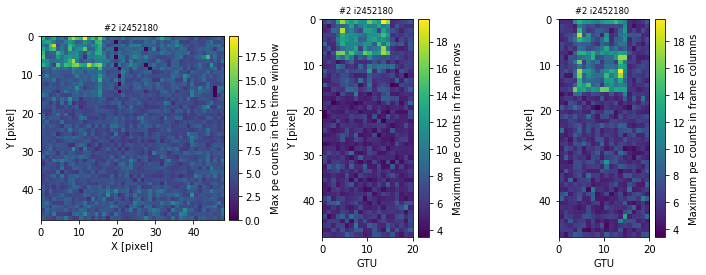

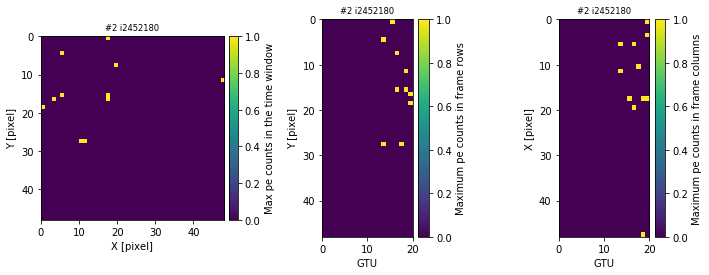

track (35038 entries)
--------------------------------------------------
#0	(0)
	event_id: 2626269
	packet_id: 1
	gtu_in_packet: 67
	num_gtu: 10
	num_frames_signals_ge_bg: 0.0
	simu2npy_signals_pathname_short: posz_33000000.00/energy_8.91e+12/thousnd33E19/simu2npy/ev_97_mc_1__signals.npy
	cond_selection_query: noise
	cond_selection_simple: track


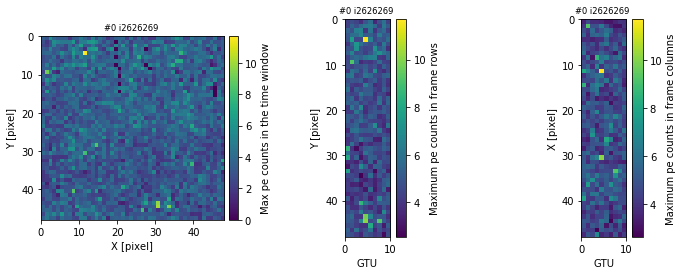

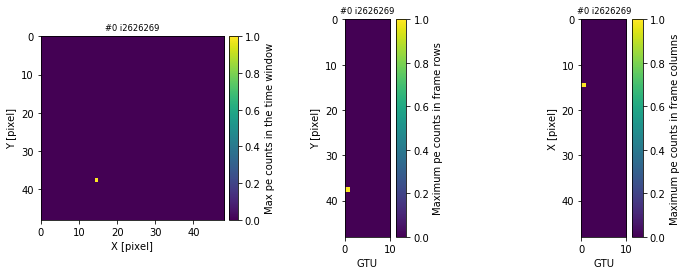

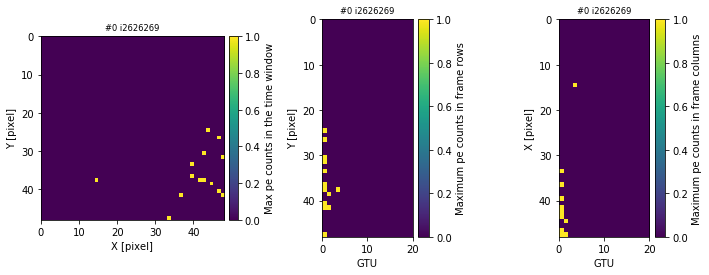

#1	(0)
	event_id: 2118783
	packet_id: 1
	gtu_in_packet: 65
	num_gtu: 12
	num_frames_signals_ge_bg: 0.0
	simu2npy_signals_pathname_short: posz_30000000.00/energy_1.58e+12/thousnd30E4/simu2npy/ev_98_mc_1__signals.npy
	cond_selection_query: noise
	cond_selection_simple: track


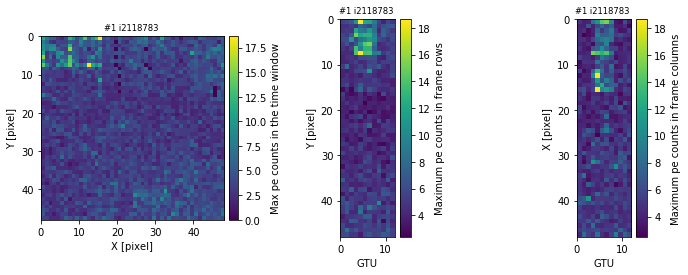

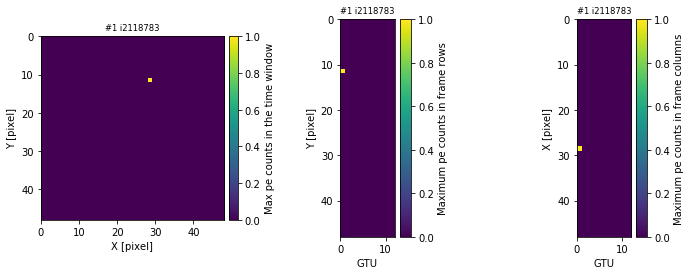

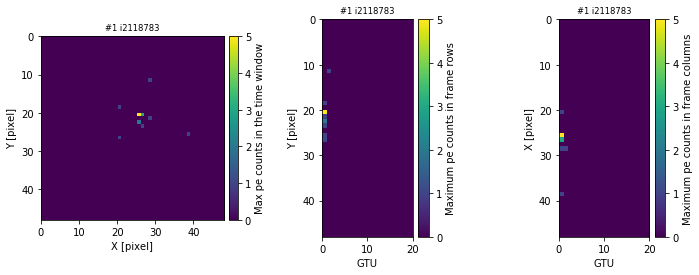

#2	(0)
	event_id: 2119602
	packet_id: 1
	gtu_in_packet: 64
	num_gtu: 16
	num_frames_signals_ge_bg: 0.0
	simu2npy_signals_pathname_short: posz_21000000.00/energy_1.58e+12/thousnd21E4.2017-07-26-21h24m15s/simu2npy/ev_20_mc_1__signals.npy
	cond_selection_query: noise
	cond_selection_simple: track


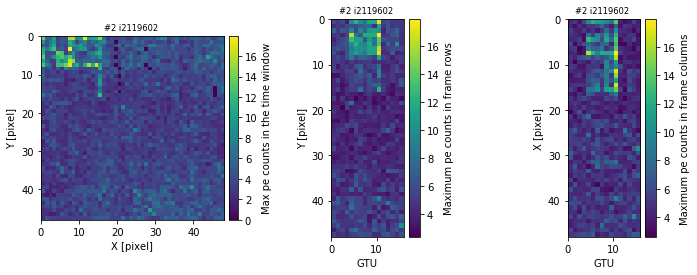

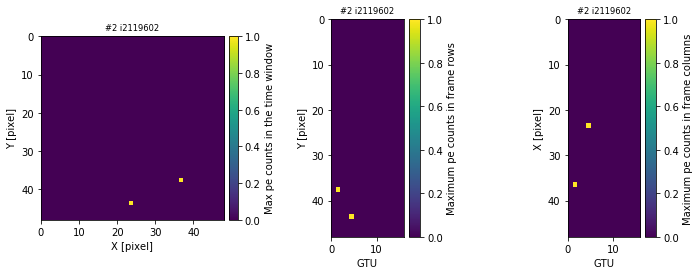

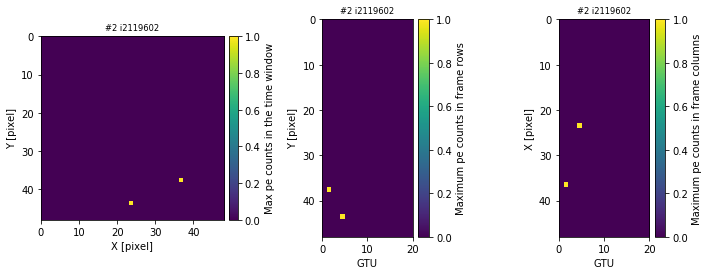

track_underflow (5983 entries)
--------------------------------------------------
#0	(0)
	event_id: 2109098
	packet_id: 1
	gtu_in_packet: 22
	num_gtu: 11
	num_frames_signals_ge_bg: nan
	simu2npy_signals_pathname_short: posz_21000000.00/energy_1.41e+12/thousnd21E3.2017-07-26-20h13m39s/simu2npy/ev_79_mc_1__signals.npy
	cond_selection_query: noise
	cond_selection_simple: track_underflow


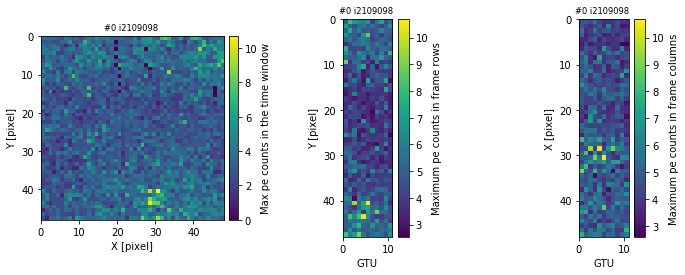

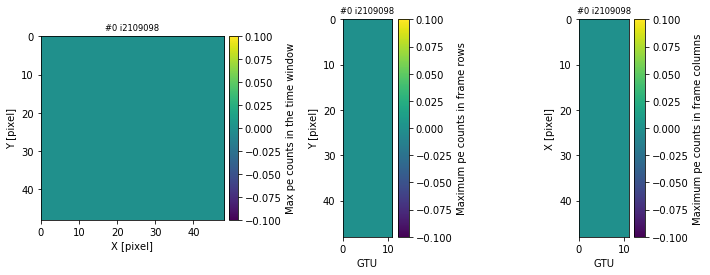

#1	(0)
	event_id: 189885
	packet_id: 1
	gtu_in_packet: 22
	num_gtu: 10
	num_frames_signals_ge_bg: nan
	simu2npy_signals_pathname_short: posz_24000000.00/energy_5.95e+12/simu.2017-07-20-20h00m16s/simu2npy/ev_16_mc_1__signals.npy
	cond_selection_query: noise
	cond_selection_simple: track_underflow


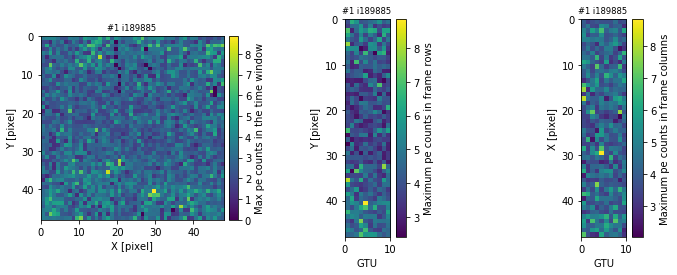

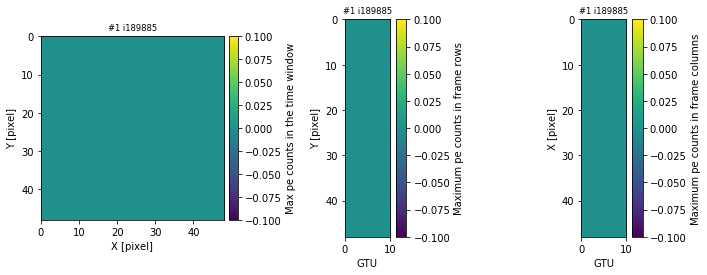

#2	(0)
	event_id: 154316
	packet_id: 1
	gtu_in_packet: 22
	num_gtu: 9
	num_frames_signals_ge_bg: nan
	simu2npy_signals_pathname_short: posz_24000000.00/energy_5.95e+12/simu.2017-07-21-05h30m38s/simu2npy/ev_59_mc_1__signals.npy
	cond_selection_query: noise
	cond_selection_simple: track_underflow


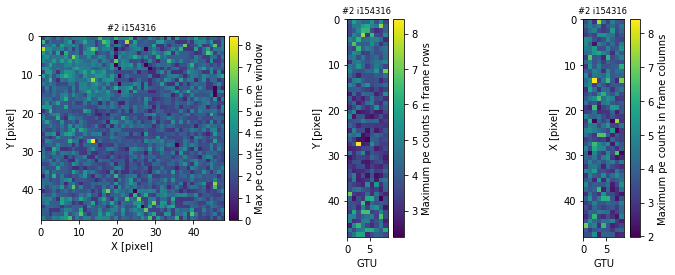

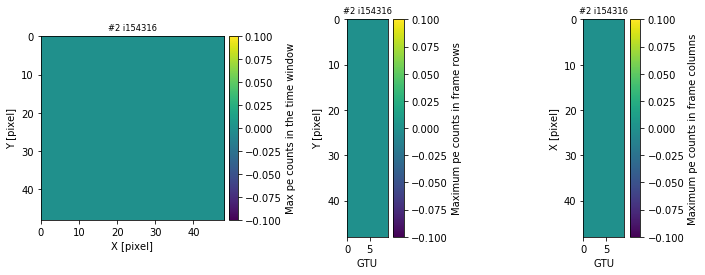

track_overflow (16956 entries)
--------------------------------------------------
#0	(0)
	event_id: 2156392
	packet_id: 1
	gtu_in_packet: 62
	num_gtu: 20
	num_frames_signals_ge_bg: nan
	simu2npy_signals_pathname_short: posz_30000000.00/energy_2.00e+12/thousnd30E6.2017-07-24-22h56m23s/simu2npy/ev_61_mc_1__signals.npy
	cond_selection_query: noise
	cond_selection_simple: track_overflow


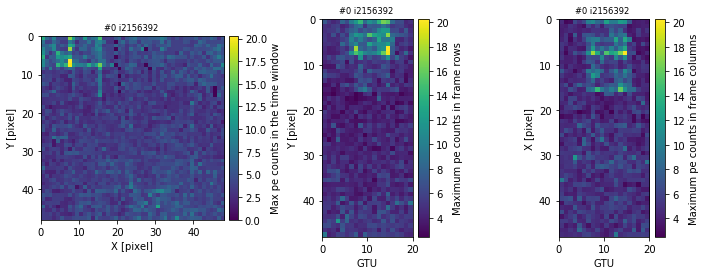

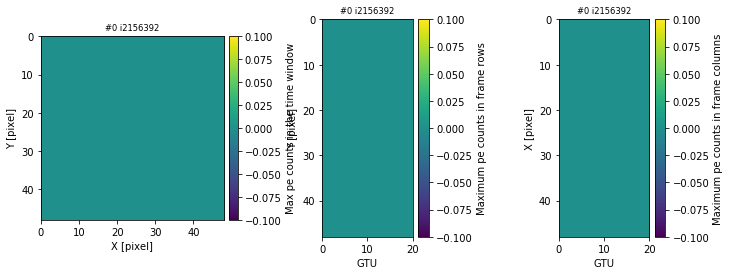

#1	(0)
	event_id: 2189735
	packet_id: 1
	gtu_in_packet: 62
	num_gtu: 10
	num_frames_signals_ge_bg: nan
	simu2npy_signals_pathname_short: posz_30000000.00/energy_1.58e+12/thousnd30E4.2017-07-24-21h02m30s/simu2npy/ev_62_mc_1__signals.npy
	cond_selection_query: noise
	cond_selection_simple: track_overflow


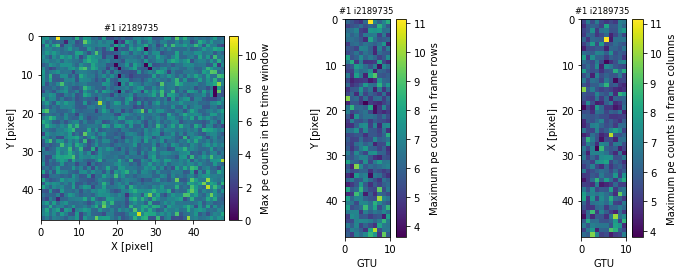

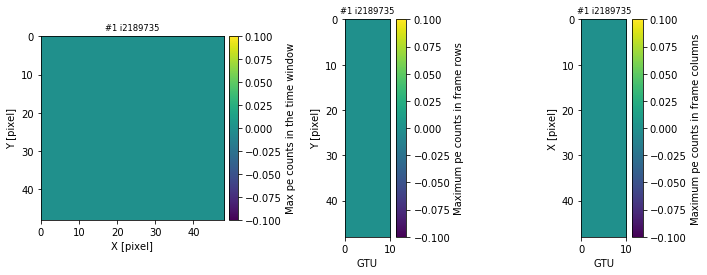

#2	(0)
	event_id: 2192502
	packet_id: 1
	gtu_in_packet: 62
	num_gtu: 14
	num_frames_signals_ge_bg: nan
	simu2npy_signals_pathname_short: posz_30000000.00/energy_1.58e+12/thousnd30E4.2017-07-24-21h10m14s/simu2npy/ev_47_mc_1__signals.npy
	cond_selection_query: noise
	cond_selection_simple: track_overflow


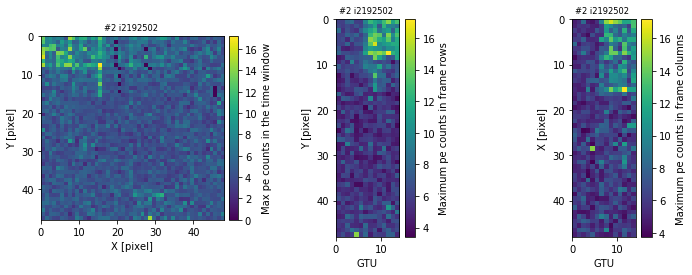

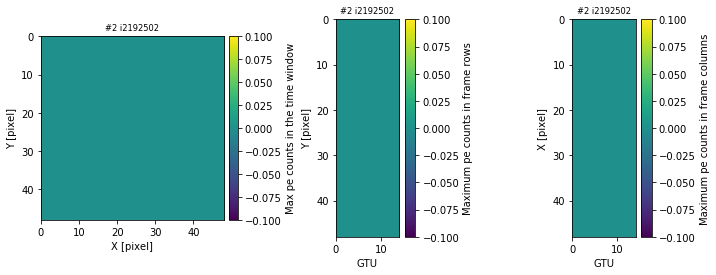

In [54]:
def vis_simu_signal_default(i, r, visualized_projections, fig, axs_flattened): 
    show_simu_event_row(i, r, 
        npy_pathname_column='simu2npy_signals_pathname', 
        single_proj_width=4, single_proj_height=4,
        print_info=False, warn_if_not_exact_simu=False)

def vis_simu_signal_with_original(i, r, visualized_projections, fig, axs_flattened):
    vis_simu_signal_default(i, r, visualized_projections, fig, axs_flattened)
    show_simu_event_row(i, r, 
        npy_pathname_column='simu2npy_signals_pathname', 
        single_proj_width=4, single_proj_height=4,
        print_info=False, warn_if_not_exact_simu=False,
        simu_gtu_override=(30,50))
    
for label, events_to_vis_df in [
        ('noise', noise_simu_df.sort_values('orig_x_y_count_nonzero', ascending=False)), 
        ('track', track_simu_df.sort_values('num_frames_signals_ge_bg', ascending=True)), 
        ('track_underflow', track_underflow_simu_df.sort_values('gtu_in_packet', ascending=False)), 
        ('track_overflow', track_overflow_simu_df.sort_values('gtu_in_packet', ascending=True))
]:
    print('{} ({} entries)'.format(label, len(events_to_vis_df)))
    print('-' * 50)
    vis_events_df(
        events_to_vis_df, 
        events_per_figure=3, max_figures=1, vis_gtux=True, vis_gtuy=True, 
        close_after_vis=False, show=True, 
        additional_printed_columns=[
            'num_frames_signals_ge_bg', 'simu2npy_signals_pathname_short', 
            'cond_selection_query', 'cond_selection_simple'],
        by_one=True,
        extension_func=vis_simu_signal_with_original if label == 'track' else vis_simu_signal_default,
        single_proj_width=4, single_proj_height=4
    )
    print('=' * 50)

### Number of NaN entries
Events with NaN values in are currently rejected from showers dataset. 
However, final decision about rejection is made considering only columns using in ML algorithm.
Therefore, these numbers are not exactly indicative of the the final number of rejected events - only simu_track and noise_track should be indicative. (TODO requires check)

#### Number of NaN entries by query and simu signal labels

In [55]:
print('{:<30} {:<10} {}'.format(' ', 'NaN', 'Others'))
for selection_query in ['simu','noise']:
    for selection_simu_signal in ['noise','track']:
        for simu_signal_sync in ['', 'underflow', 'overflow']:
            t_selection_simu_signal = selection_simu_signal
            if len(simu_signal_sync) > 0:
                t_selection_simu_signal += '_' + simu_signal_sync
            subset_df = combined_simu_df[
                (combined_simu_df['cond_selection_query'] == selection_query ) & 
                (combined_simu_df['cond_selection_simple'] == t_selection_simu_signal)
            ]
            nan_row_count = np.count_nonzero(subset_df.isnull().any(axis=1))
            print('{:<30} {:<10} {}'.format(
                '{} - {}'.format(selection_query, t_selection_simu_signal),
                nan_row_count, len(subset_df) - nan_row_count
            ))

                               NaN        Others
simu - noise                   2          2
simu - noise_underflow         0          0
simu - noise_overflow          0          0
simu - track                   2699       31822
simu - track_underflow         0          0
simu - track_overflow          0          0
noise - noise                  1604       0
noise - noise_underflow        24689      0
noise - noise_overflow         70838      0
noise - track                  517        0
noise - track_underflow        5983       0
noise - track_overflow         16956      0


Flight data were already selected excluding entries with NaN values (actually NULL in PostgreSQL table).

In [56]:
for subset_label, subset_df in flight_df_dict.items():
    print('{:50}: {:d}'.format(subset_label, np.count_nonzero(subset_df.isnull().any(axis=1))))

unl_noise_flight_df                               : 43408
lbl_noise_flight_df                               : 543
unl_flight_df                                     : 0


#### NaN columns
Columns with a NaN value are either data from Hough transform on projections of triggered pixels - issue is a single pixel in a projection, thus it is impossible to determine orientation of a line. This impacts usable size of the dataset.
Other source of NaN values are additional information calculated for simulated shower - it is number of frames where number of signal pixels satisfies certain condition. The NaN value is present when there are no signal present in an identified event.

In [57]:
nan_columns = {}

for i, r in combined_simu_df[combined_simu_df.isnull().any(axis=1)].iterrows():
    for col, val in r.iteritems():
        if isinstance(val, numbers_Number) and math.isnan(val):
            if col not in nan_columns:
                nan_columns[col] = 0
            nan_columns[col] += 1

for col, val in nan_columns.items():
    print("{:<120} : {:<d}".format(col, val))

# del nan_columns

trg_gtu_y_hough_peak_thr1_major_line_phi                                                                                 : 2207
trg_gtu_x_hough_peak_thr1_major_line_phi                                                                                 : 2209
trg_x_y_hough_peak_thr1_major_line_phi                                                                                   : 1776
etruth_trueshowermaxpos_x                                                                                                : 128793
etruth_trueshowermaxpos_y                                                                                                : 128793
etruth_trueshowermaxpos_z                                                                                                : 128793
num_frames_counts_gt_bg                                                                                                  : 123329
num_frames_signals_ge_bg                                                                        

### Free memory
(not in the report)

In [58]:
if 'unclassified_simu_df' in locals(): del unclassified_simu_df
if 'track_simu_df' in locals(): del track_simu_df
if 'noisy_simu_df' in locals(): del noisy_simu_df
if 'simu_signal_track_events_df' in locals(): del simu_signal_track_events_df
if 'simu_signal_noisy_events_df' in locals(): del simu_signal_noisy_events_df

In [59]:
# unclassified_simu_df, \
# track_simu_df, track_underflow_simu_df, track_overflow_simu_df, \
# noise_simu_df, noise_underflow_simu_df, noise_overflow_simu_df, \
# simu_signal_track_events_df, simu_signal_noisy_events_df

## Preparation of the testing and training datasets

Selected datasets are used in training and testing of a machine learning algorithm. 
Because of different inital number of noise and shower events, sizes of the datasets need to be balanced. This is done by decreasing a size of a smaller dataset.

Another potential solution would be to change class weights in the configuration of a machine learning algorithm.

### Column names
(not in the report)

In [60]:
dataset_condenser_df_columns = list(common_df_columns)
for col in [  
#         'event_id',
#         'source_file_acquisition_full',
        'source_file_trigger_full',
        'source_file_acquisition',
        'source_file_trigger',
        'global_gtu',
#         'packet_id',
#         'gtu_in_packet',
        'orig_x_y_count_nonzero',
        'bg_x_y_count_nonzero',
        'bg_count_nonzero',
        'orig_count_nonzero',
        'bg_size'

]:
    if col in dataset_condenser_df_columns:
        dataset_condenser_df_columns.remove(col)

# IMPORTANT - NaN columns excluded from the analysis
    
for col in nan_columns.keys():
    if col in dataset_condenser_df_columns:
        dataset_condenser_df_columns.remove(col)
    
simu_class_column = 'cond_selection_combined'
flight_class_column = classification_df_cls_column_name
    
dataset_condenser_df_columns_w_event_id = list(dataset_condenser_df_columns)
if 'event_id' not in dataset_condenser_df_columns:
    dataset_condenser_df_columns_w_event_id.append('event_id')
dataset_condenser_df_columns_w_event_id_simu_class = list(dataset_condenser_df_columns_w_event_id) + [simu_class_column]
dataset_condenser_df_columns_w_event_id_flight_class = list(dataset_condenser_df_columns_w_event_id) + [flight_class_column]

In [61]:
dataset_condenser_df_columns

['event_id',
 'source_file_acquisition_full',
 'packet_id',
 'gtu_in_packet',
 'num_gtu']

In [62]:
mpl.rcParams['backend']

'module://ipykernel.pylab.backend_inline'

In [63]:
%matplotlib inline

In [64]:
mpl.rcParams['backend']

'module://ipykernel.pylab.backend_inline'

In [65]:
'get_ipython' in globals()

True

### Showers dataset
Showers dataset consists of processed simulated showers that belong to the **"simu track"** class and potentially flight events classified as an air shower.

Another potential source in the future might consist set of laser shots from Utah tests.

In [66]:
def query_simu_track(df):
    return df.query('cond_selection_combined == "simu_track"')

def query_event_class_shower(df):
    return df.query(
        '{classification_df_cls_column_name} == {event_class_shower}'.format(
            classification_df_cls_column_name=classification_df_cls_column_name,
            event_class_shower=EVENT_CLASSES['shower']
        )
    )


# this function is pointeless
# _flight_class
def get_labeled_shower(columns=dataset_condenser_df_columns_w_event_id):
    #  unsuitable name of the dict item
    #  expected to be empty
    return query_event_class_shower(flight_df_dict['lbl_noise_flight_df']) \
        [columns] \
        .dropna()

# _simu_class
def get_simu_shower_track(columns=dataset_condenser_df_columns_w_event_id):
    return query_simu_track(combined_simu_df) \
        [columns] \
        .dropna()

In [67]:
EVENT_CLASS_LABELED_SHOWER_FLIGHT = 2
EVENT_CLASS_SIMU_TRACK = 1

In [68]:
shower_subset_df_funcs_dict = {
    'lbl_shower_flight_df': get_labeled_shower,
    'combined_simu_df_shower_track': get_simu_shower_track
}

shower_subset_class_numbers_dict = {
    'lbl_shower_flight_df': EVENT_CLASS_LABELED_SHOWER_FLIGHT,
    'combined_simu_df_shower_track': EVENT_CLASS_SIMU_TRACK
}
shower_subset_priority_order = ['lbl_shower_flight_df', 'combined_simu_df_shower_track']

def get_shower_subsets_list(
        df_columns={
            'lbl_shower_flight_df': dataset_condenser_df_columns_w_event_id,
            'combined_simu_df_shower_track': dataset_condenser_df_columns_w_event_id
        }, 
        shower_subset_df_funcs_dict=shower_subset_df_funcs_dict,
        shower_subset_priority_order=shower_subset_priority_order
):
    shower_subsets_list = []
    
    for shower_subset_label in shower_subset_priority_order:
        
        this_df_columns = df_columns[shower_subset_label] \
            if isinstance(df_columns, dict) else df_columns
        
        shower_subsets_list.append(
            shower_subset_df_funcs_dict[shower_subset_label](this_df_columns)
        )
    
    return shower_subsets_list

shower_subsets_list = get_shower_subsets_list()

In [69]:
showers_nonan_w_event_id_df = pd.concat(shower_subsets_list)

Total size of the simualated showers dataset:

In [70]:
print('len(showers_nonan_w_event_id_df)', len(showers_nonan_w_event_id_df))

len(showers_nonan_w_event_id_df) 34521


### Non-showers dataset
Noise dataset is presently constructed from three subsets, in the follwing priority
1. **Classified noise** - *Flight labeled events* excluding classes `shower` and `unspecified`.
2. **Unclassified flight** - Dataset of noise of that triggered using configuration with decreased thresholds (bgf=0.5) outside of window of expected cause of the hardware trigger in GTU 40 (Dataset *Flight improbable events* - 20 GTU before or after GTU 42). 
3. **Overflow simu** - In principle same as **unclassified flight** but on simu simulation - frames consist of a repeating sequence. The entries should be slightly more different form the **unclassified flight** than **underflow simu**. That's set events should be generally shorter than than the repeated sequence length, on the other hand, **overflow simu** contains some events of containing repetition of the frames sequence (should be verified).
3. **Unclassified simu** - In principle same as **unclassified flight** but on simu simulation - **overflow** and **noise noise"** classified events.

In [71]:
EVENT_CLASS_NUMBER_SIMU_OVERFLOW = 0
EVENT_CLASS_NUMBER_SIMU_NOISE_NOISE = -4
EVENT_CLASS_NUMBER_SIMU_UNDERFLOW = -5

In [72]:
def query_labeled_flight_noise(df):
    return df.query(
        '{classification_df_cls_column_name} >= {min_class_number:d} ' \
        'and {classification_df_cls_column_name} not in ({event_class_shower}, {event_class_unspecified})'.format(
            classification_df_cls_column_name=classification_df_cls_column_name,
            min_class_number=min(EVENT_CLASSES.values()),
            event_class_shower=EVENT_CLASSES['shower'],
            event_class_unspecified=EVENT_CLASSES['unspecified']
    ))

def query_unlabeled_flight_noise(df):
    return df.query('{classification_df_cls_column_name} == {EVENT_CLASS_NUMBER_UNLABELED_NOISE:d}'.format(
        classification_df_cls_column_name=classification_df_cls_column_name, 
        EVENT_CLASS_NUMBER_UNLABELED_NOISE=EVENT_CLASS_NUMBER_UNLABELED_NOISE,
    ))
    
def query_simu_noise_noise(df):
    return df.query('cond_selection_combined == "noise_noise"')

def query_simu_overflow(df):
    return df[df['cond_selection_simple'].isin(['noise_overflow', 'track_overflow'])]

def query_simu_underflow(df):
    return df[df['cond_selection_simple'].isin(['noise_underflow', 'track_underflow'])]

def concatenate_balanced(df_list):
    min_len = min([len(t_df) for t_df in df_list])
    df_shortened = [(t_df.iloc[np.random.randint(0, len(t_df), min_len)] if len(t_df) > min_len else t_df) \
                    for t_df in df_list]
    return pd.concat(df_shortened)

def get_labeled_flight_noise(columns=dataset_condenser_df_columns_w_event_id_flight_class):
    return query_labeled_flight_noise(flight_df_dict['lbl_noise_flight_df']) \
        [columns] \
        .dropna()

def get_unlabeled_flight_noise(columns=dataset_condenser_df_columns_w_event_id_flight_class):
    return query_unlabeled_flight_noise(flight_df_dict['unl_noise_flight_df']) \
        [columns] \
        .dropna()

def get_simu_noise_noise(columns=dataset_condenser_df_columns_w_event_id_simu_class):
    return query_simu_noise_noise(combined_simu_df) \
        [columns] \
        .dropna()

def get_simu_overflow(columns=dataset_condenser_df_columns_w_event_id_simu_class):
    return query_simu_overflow(combined_simu_df) \
        [columns] \
        .dropna()

def get_simu_underflow(columns=dataset_condenser_df_columns_w_event_id_simu_class):
    return query_simu_underflow(combined_simu_df) \
        [columns] \
        .dropna()

Size of the dataset in progressively extended by non-shower data until it as large as shower data dataset. 
If required number of events is lower than size of a subset, events are randomly sampled from the subset.

In [73]:
noise_subset_df_funcs_dict = {
    'lbl_noise_flight_df': get_labeled_flight_noise, 
    'unl_noise_flight_df': get_unlabeled_flight_noise,
    'combined_simu_df_overflow': get_simu_overflow,
    'combined_simu_df_noise_noise': get_simu_noise_noise,
    'combined_simu_df_underflow': get_simu_underflow,
}

noise_subset_class_numbers_dict = {
    'lbl_noise_flight_df': EVENT_CLASS_LABLELED_NOISE_FLIGHT, 
    'unl_noise_flight_df': EVENT_CLASS_NUMBER_UNLABELED_NOISE, 
    'combined_simu_df_overflow': EVENT_CLASS_NUMBER_SIMU_OVERFLOW,
    'combined_simu_df_noise_noise': EVENT_CLASS_NUMBER_SIMU_NOISE_NOISE,
    'combined_simu_df_underflow': EVENT_CLASS_NUMBER_SIMU_UNDERFLOW
}

noise_subset_priority_order = [
    'lbl_noise_flight_df', 'unl_noise_flight_df', 
    #'combined_simu_df_overflow', 'combined_simu_df_noise_noise', 'combined_simu_df_underflow'
]

np.random.seed(123)

# -----------------------------------------------------------

def get_non_shower_subsets_list(
        df_columns={
            'lbl_noise_flight_df': dataset_condenser_df_columns_w_event_id,  #_flight_class,
            'unl_noise_flight_df': dataset_condenser_df_columns_w_event_id,  #_flight_class,
            'combined_simu_df_overflow': dataset_condenser_df_columns_w_event_id,  #_simu_class,
            'combined_simu_df_noise_noise': dataset_condenser_df_columns_w_event_id,  #_simu_class,
            'combined_simu_df_underflow': dataset_condenser_df_columns_w_event_id,  #_simu_class,
        }, 
        noise_subset_df_funcs_dict=noise_subset_df_funcs_dict,
        noise_subset_priority_order=noise_subset_priority_order,
        len_limit=len(showers_nonan_w_event_id_df)
):

    non_shower_subsets_list = []
    non_shower_subsets_tot_len = 0
    for noise_subset_label in noise_subset_priority_order:
        get_non_shower_events_func = noise_subset_df_funcs_dict[noise_subset_label]
        
        this_df_columns = df_columns[noise_subset_label] \
            if isinstance(df_columns, dict) else df_columns
        
        non_shower_subset_df = get_non_shower_events_func(this_df_columns)
        new_len = len(non_shower_subset_df) + non_shower_subsets_tot_len

        print('Current subset size: {:<7} ; Added {:<30} subset size: {:<7} ; ' \
              'Potentional new dataset size: {:<7} ; Required size: {:<7}'.format(
            non_shower_subsets_tot_len, noise_subset_label, len(non_shower_subset_df),
            new_len, len_limit
        ))

        if new_len > len_limit:
            non_shower_subset_df = \
                non_shower_subset_df.iloc[
                    np.random.randint(0, len(non_shower_subset_df), 
                                      len_limit - non_shower_subsets_tot_len)
            ]

        non_shower_subsets_list.append(non_shower_subset_df)
        non_shower_subsets_tot_len += len(non_shower_subset_df)

        if new_len >= len_limit:
            break
            
    return non_shower_subsets_list

# -------------------------------------------------------------
            
non_shower_subsets_list = get_non_shower_subsets_list()

Current subset size: 0       ; Added lbl_noise_flight_df            subset size: 2619    ; Potentional new dataset size: 2619    ; Required size: 34521  
Current subset size: 2619    ; Added unl_noise_flight_df            subset size: 56229   ; Potentional new dataset size: 58848   ; Required size: 34521  


In [74]:
non_showers_nonan_w_event_id_df = pd.concat(non_shower_subsets_list)

Total number of noise subset required:

In [75]:
len(non_shower_subsets_list)

2

Concatenated noise subsets total size:

In [76]:
print(len(non_showers_nonan_w_event_id_df))

34521


### Concatenated arrays (np.ndarray)
(not in the report)

Transformation of multiple `pandas.DataFrame` objects into concatenated `numpy.ndarray`. 
Following arrays are created:
- `packets` - training data for an algorithm - packet data - source_file, packet_id, gtu_in_packet
- `y` - training data for an algorithm - labels
- `event_id` - event id of the data in the dataset - important after `test_train_split()`, used to associate predictions with the original events
- `source_class` - source class of the data in the dataset - important after `test_train_split()`, used to associate predictions with the original events, especially to be able to expres accuracy of predictions for a specific source class of data - e.g. label flight noise events

In [77]:
learning_data_dict = {
    'test': {},
    'train': {},
    'all': pd.concat([
        showers_nonan_w_event_id_df[dataset_condenser_df_columns], 
        non_showers_nonan_w_event_id_df[dataset_condenser_df_columns]
    ])
}
learning_data_dict['all']['target_class'] = np.concatenate([
    np.ones(len(showers_nonan_w_event_id_df)), 
    np.zeros(len(non_showers_nonan_w_event_id_df))
])      
learning_data_dict['all']['source_class'] = np.concatenate([
    *[np.ones(len(shower_subset_df)) * shower_subset_class_numbers_dict[shower_subset_label] \
      for shower_subset_df, shower_subset_label in zip(shower_subsets_list, shower_subset_priority_order)],
    *[np.ones(len(non_shower_subset_df)) * noise_subset_class_numbers_dict[noise_subset_label] \
      for non_shower_subset_df, noise_subset_label in zip(non_shower_subsets_list, noise_subset_priority_order)]
])

In [78]:
def calc_learning_data_weights(learning_data__y, learning_data__source_class, print_info=True):
    
    learning_data__weights = np.ones_like(learning_data__y)
    
    uniq_noise_source_classes = np.unique(learning_data__source_class[learning_data__y != 1])

    num_shower_events = np.count_nonzero(learning_data__y == 1)
    num_noise_events = len(learning_data__y) - num_shower_events

    k = num_shower_events / (len(uniq_noise_source_classes) * num_noise_events)

    for noise_source_class in uniq_noise_source_classes:
        noise_source_class_mask = learning_data__source_class == noise_source_class
        
        num_noise_source_class = np.count_nonzero(noise_source_class_mask)

        w =  k * num_noise_events / num_noise_source_class 

        learning_data__weights[noise_source_class_mask] = w
        
        if print_info:
            print('{}: w={:.4f}, k={:.4f}, num_source_class={:<8.1f}, norm_num_source_class={:<8.1f}, 1/frac_noise={:.4f}, frac_noise={:.4f}, '.format(
                noise_source_class, w, k, 
                num_noise_source_class, 
                w*num_noise_source_class , 
                num_noise_events / num_noise_source_class, 
                num_noise_source_class / num_noise_events
            ))
    
    if print_info:
        s = np.sum(learning_data__weights[learning_data__y == 0])
        print('sum weights = {:.4f} , per class = {:.4f}'.format(s, s/len(uniq_noise_source_classes)))
    
    return learning_data__weights
        
learning_data_dict['all']['weights'] = \
    calc_learning_data_weights(learning_data_dict['all']['target_class'], learning_data_dict['all']['source_class'])

-3.0: w=6.5905, k=0.5000, num_source_class=2619.0  , norm_num_source_class=17260.5 , 1/frac_noise=13.1810, frac_noise=0.0759, 
-2.0: w=0.5410, k=0.5000, num_source_class=31902.0 , norm_num_source_class=17260.5 , 1/frac_noise=1.0821, frac_noise=0.9241, 
sum weights = 34521.0000 , per class = 17260.5000


### Labeled concatenated dataset (pd.DataFrame)
(not in the report)

In [79]:
learning_data_dict['all']['source_class'].unique()

array([ 1., -3., -2.])

### Train-test split

The data are split into training and testing subsets in **60:40** ratio. The data are shuffled before splitting, thus there should not be a significat difference in ratios of source clases of the data within the testing and training sets.

In [80]:
learning_data_dict['train'], learning_data_dict['test'] = \
    (pd.DataFrame(_df) for _df in sklearn.model_selection.train_test_split(
        learning_data_dict['all'],
        test_size=.4, 
        random_state=123, 
        shuffle=True
    ))

In [81]:
for subset_name in ['train', 'test']:
    print('Subset:', subset_name)
    learning_data_dict[subset_name]['weights'] = calc_learning_data_weights(
        learning_data_dict[subset_name]['target_class'], learning_data_dict[subset_name]['source_class'], print_info=True)

Subset: train
-3.0: w=6.4672, k=0.4998, num_source_class=1601.0  , norm_num_source_class=10354.0 , 1/frac_noise=12.9400, frac_noise=0.0773, 
-2.0: w=0.5416, k=0.4998, num_source_class=19116.0 , norm_num_source_class=10354.0 , 1/frac_noise=1.0838, frac_noise=0.9227, 
sum weights = 20708.0000 , per class = 10354.0000
Subset: test
-3.0: w=6.7844, k=0.5003, num_source_class=1018.0  , norm_num_source_class=6906.5  , 1/frac_noise=13.5599, frac_noise=0.0737, 
-2.0: w=0.5402, k=0.5003, num_source_class=12786.0 , norm_num_source_class=6906.5  , 1/frac_noise=1.0796, frac_noise=0.9263, 
sum weights = 13813.0000 , per class = 6906.5000


#### Number of entries in training and testing datasets

In [82]:
for subset_name, _df in learning_data_dict.items():
    print('{:>5}: {}'.format(subset_name, len(_df)))

 test: 27617
train: 41425
  all: 69042


#### Number of entries in training and testing datasets by a class (shower, non-shower)

In [83]:
print('Num. non-shower entries in train', np.count_nonzero(learning_data_dict['train']['target_class'] == 0))
print('Num. shower entries in train    ', np.count_nonzero(learning_data_dict['train']['target_class'] == 1))
print('Num. non-shower entries in test ', np.count_nonzero(learning_data_dict['test']['target_class'] == 0))
print('Num. shower entries in test     ', np.count_nonzero(learning_data_dict['test']['target_class'] == 1))

Num. non-shower entries in train 20717
Num. shower entries in train     20708
Num. non-shower entries in test  13804
Num. shower entries in test      13813


In [246]:
learning_data__simu_shower_track_mask_arr_all = \
    np.array(learning_data_dict['all']['source_class'] == shower_subset_class_numbers_dict['combined_simu_df_shower_track'])
learning_data__simu_shower_track_mask_arr_test = \
    np.array(learning_data_dict['test']['source_class'] == shower_subset_class_numbers_dict['combined_simu_df_shower_track'])

learning_data__lbl_noise_flight_mask_arr_all = \
    np.array(learning_data_dict['all']['source_class'] == noise_subset_class_numbers_dict['lbl_noise_flight_df'])
learning_data__lbl_noise_flight_mask_arr_train = \
    np.array(learning_data_dict['train']['source_class'] == noise_subset_class_numbers_dict['lbl_noise_flight_df'])
learning_data__lbl_noise_flight_mask_arr_test = \
    np.array(learning_data_dict['test']['source_class'] == noise_subset_class_numbers_dict['lbl_noise_flight_df'])

#### Number of entries in training and testing datasets considering only labeled noise

In [85]:
print('lbl_noise_flight_df in train', np.count_nonzero(learning_data__lbl_noise_flight_mask_arr_train))
print('lbl_noise_flight_df in test ', np.count_nonzero(learning_data__lbl_noise_flight_mask_arr_test))

lbl_noise_flight_df in train 1601
lbl_noise_flight_df in test  1018


### Data dump

In [121]:
# functions have been copied to data_analysis_utils.py

def get_first_packet_frame_num(
        r, packet_id_column='packet_id', gtu_in_packet_column='gtu_in_packet', packet_size=128, gtu_in_packet_offset=-4,
        int_func=int, max_func=max
):
    gtu_packet_offset = int_func(r[packet_id_column]) * packet_size
    total_gtu_offset = gtu_packet_offset + int_func(r[gtu_in_packet_column]) + gtu_in_packet_offset
    return max_func((total_gtu_offset, gtu_packet_offset))

def get_last_packet_frame_num_high(
        r, packet_id_column='packet_id', gtu_in_packet_column='gtu_in_packet', num_gtu_column='num_gtu', num_gtu_overwrite=None,
        packet_size=128, gtu_in_packet_offset=-4,
        int_func=int, max_func=max, min_func=min
):
    next_gtu_packet_offset = (int_func(r[packet_id_column]) + 1) * packet_size

    num_gtu = int_func(r[num_gtu_column]) if num_gtu_overwrite is None else num_gtu_overwrite
    last_frame_num_high = num_gtu + \
        get_first_packet_frame_num(r, packet_id_column=packet_id_column, gtu_in_packet_column=gtu_in_packet_column, 
            packet_size=packet_size, gtu_in_packet_offset=gtu_in_packet_offset,
            int_func=int_func, max_func=max_func)
        
    return min_func((last_frame_num_high, next_gtu_packet_offset))

def get_first_packet_frame_num_in_df(
        r, packet_id_column='packet_id', gtu_in_packet_column='gtu_in_packet', 
        packet_size=128, gtu_in_packet_offset=-4,
        int_func=lambda x:x, max_func=lambda x: np.max(x, axis=0)
):
    return get_first_packet_frame_num(
        r, packet_id_column=packet_id_column, gtu_in_packet_column=gtu_in_packet_column, 
        packet_size=packet_size, gtu_in_packet_offset=gtu_in_packet_offset,
        int_func=int_func, max_func=max_func
    )

def get_last_packet_frame_num_high_in_df(
        r, packet_id_column='packet_id', gtu_in_packet_column='gtu_in_packet', num_gtu_column='num_gtu', num_gtu_overwrite=None,
        packet_size=128, gtu_in_packet_offset=-4,
        int_func=lambda x:x, max_func=lambda x: np.max(x, axis=0), min_func=lambda x: np.min(x, axis=0)
):
    return get_last_packet_frame_num_high(
        r, packet_id_column=packet_id_column, gtu_in_packet_column=gtu_in_packet_column, num_gtu_column=num_gtu_column, 
        num_gtu_overwrite=num_gtu_overwrite,
        packet_size=packet_size, gtu_in_packet_offset=gtu_in_packet_offset,
        int_func=int_func, max_func=max_func, min_func=min_func
    )

def make_frame_sequence_projection(proj_label, frames_sequence):
    if proj_label == 'x_y':
        proj_image = np.max(frames_sequence, axis=0)
    elif proj_label == 'gtu_y':
        proj_image = np.transpose(np.max(frames_sequence, axis=2))
    elif proj_label == 'gtu_x':
        proj_image = np.transpose(np.max(frames_sequence, axis=1))
    return proj_image

def make_frame_sequence_projection_no_transpose(proj_label, frames_sequence):
    if proj_label == 'x_y':
        proj_image = np.max(frames_sequence, axis=0)
    elif proj_label == 'gtu_y':
        proj_image = np.max(frames_sequence, axis=2)
    elif proj_label == 'gtu_x':
        proj_image = np.max(frames_sequence, axis=1)
    return proj_image


def get_frame_array(
        all_rows, transform_func=make_frame_sequence_projection,
        return_x_y=True, return_gtu_x=False, return_gtu_y=False, return_offsets=False,
        event_id_column='event_id', packet_id_column='packet_id', gtu_in_packet_column='gtu_in_packet', num_gtu_column='num_gtu',
        source_file_acquisition_full_column='source_file_acquisition_full',
        inverse_means_arr=None,
        get_first_frame_num_func=get_first_packet_frame_num,
        get_last_frame_num_high_func=get_last_packet_frame_num_high,
        print_info=True, allow_not_exists=False, status_update_every=100,
        x_y_num_gtu_overwrite=None, gtu_x_num_gtu_overwrite=None, gtu_y_num_gtu_overwrite=None,
        packet_size=128, gtu_in_packet_offset=-4
):
    import pandas as pd
    import datetime

    visualized_projections_x_y = []
    visualized_projections_gtu_x = []
    visualized_projections_gtu_y = []

    num_npy = 0
    num_root = 0
    
    if print_info:
        t0 = datetime.datetime.now()
        print('Extracting frames start: {:%Y:%m:%d %H:%M:%S}'.format(t0))
    
    ####
    
    num_gtu_dict = {'x_y': x_y_num_gtu_overwrite, 'gtu_x': gtu_x_num_gtu_overwrite, 'gtu_y': gtu_y_num_gtu_overwrite}
    abs_start_frame_arr_dict = {'x_y': None, 'gtu_x': None, 'gtu_y': None}
    abs_end_frame_arr_dict = {'x_y': None, 'gtu_x': None, 'gtu_y': None}
    arr_slice_start_corr_arr_dict = {'x_y': None, 'gtu_x': None, 'gtu_y': None}
    # arr_slice_len  - same as num_gtu_dict
        
    abs_start_frame_arr = np.array(get_first_packet_frame_num_in_df(
        all_rows, packet_size=packet_size, gtu_in_packet_offset=gtu_in_packet_offset))

    abs_end_frame_arr = np.array(get_last_packet_frame_num_high_in_df(
        all_rows, packet_size=packet_size, gtu_in_packet_offset=gtu_in_packet_offset))
    
    for proj_label, num_gtu_overwrite in num_gtu_dict.items():
        
        if num_gtu_overwrite is None:
            abs_start_frame_arr_dict[proj_label] = abs_start_frame_arr
            abs_end_frame_arr_dict[proj_label] = abs_end_frame_arr
            num_gtu_dict[proj_label] = np.array(all_rows[num_gtu_column])  # memory inefficient
        else:
            abs_end_frame_at_owr_gtu_arr = np.array(get_last_packet_frame_num_high_in_df(
                all_rows, 
                num_gtu_overwrite=np.maximum(np.array(all_rows[num_gtu_column]), num_gtu_overwrite), 
                packet_size=packet_size, gtu_in_packet_offset=gtu_in_packet_offset))
            
            d = abs_end_frame_at_owr_gtu_arr - abs_start_frame_arr
            d_lt_num_gtu_overwrite_mask = d < num_gtu_overwrite

            abs_start_frame_at_owr_gtu_arr = np.array(abs_start_frame_arr)
                
            abs_start_frame_at_owr_gtu_arr[d_lt_num_gtu_overwrite_mask] = \
                abs_start_frame_arr[d_lt_num_gtu_overwrite_mask] - (num_gtu_overwrite - d[d_lt_num_gtu_overwrite_mask])
            
            check_start_frame_at_owr_gtu_mask = \
                abs_start_frame_at_owr_gtu_arr[d_lt_num_gtu_overwrite_mask] < all_rows[packet_id_column][d_lt_num_gtu_overwrite_mask]*packet_size

            if np.any(check_start_frame_at_owr_gtu_mask):
                print(np.count_nonzero(check_start_frame_at_owr_gtu_mask))
                # inefficient to increase compatibility
                first_event_id =  np.array(all_rows[event_id_column][d_lt_num_gtu_overwrite_mask][check_start_frame_at_owr_gtu_mask])[0]
                first_gtu_in_packet = np.array(all_rows[gtu_in_packet_column][d_lt_num_gtu_overwrite_mask][check_start_frame_at_owr_gtu_mask])[0]
                first_packet_id = np.array(all_rows[packet_id_column][d_lt_num_gtu_overwrite_mask][check_start_frame_at_owr_gtu_mask])[0]
                first_num_gtu = np.array(all_rows[num_gtu_column][d_lt_num_gtu_overwrite_mask][check_start_frame_at_owr_gtu_mask])[0]
                first_start_frame_at_owr_gtu = abs_start_frame_at_owr_gtu_arr[d_lt_num_gtu_overwrite_mask][check_start_frame_at_owr_gtu_mask][0]
                first_end_frame_at_owr_gtu = abs_end_frame_at_owr_gtu_arr[d_lt_num_gtu_overwrite_mask][check_start_frame_at_owr_gtu_mask][0]
                first_start_frame = abs_start_frame_arr[d_lt_num_gtu_overwrite_mask][check_start_frame_at_owr_gtu_mask][0]
                first_end_frame = abs_end_frame_arr[d_lt_num_gtu_overwrite_mask][check_start_frame_at_owr_gtu_mask][0]
                first_lower_packet_bound = (np.array(all_rows[packet_id_column][d_lt_num_gtu_overwrite_mask][check_start_frame_at_owr_gtu_mask])*packet_size)[0]
                
                raise RuntimeError(
                    'Cannot accommodate sufficient window of packet frames in projection {proj}, num_gtu_overwrite={num_gtu_overwrite}. '
                    '(First invalid entry: event_id={event_id}, gtu_in_packet={gtu_in_packet}, num_gtu={num_gtu}, packet_id={packet_id}, '
                    'computed frame range w/o overwrite=[{start_frame},{end_frame}], '
                    'computed frame range w/ overwrite=[{start_frame_at_owr_gtu},{end_frame_at_owr_gtu}], '
                    'packet_bounds=[{lower_packet_bound}, {higher_packet_bound}])'.format(
                        proj=proj_label, num_gtu_overwrite=num_gtu_overwrite,
                        event_id=first_event_id, 
                        gtu_in_packet=first_gtu_in_packet,
                        num_gtu=first_num_gtu, packet_id=first_packet_id,
                        start_frame_at_owr_gtu=first_start_frame_at_owr_gtu,
                        end_frame_at_owr_gtu=first_end_frame_at_owr_gtu,
                        start_frame=first_start_frame,
                        end_frame=first_end_frame,
                        lower_packet_bound=first_lower_packet_bound, 
                        higher_packet_bound=first_lower_packet_bound + packet_size
                ))

            abs_start_frame_arr_dict[proj_label] = abs_start_frame_at_owr_gtu_arr
            abs_end_frame_arr_dict[proj_label] = abs_end_frame_at_owr_gtu_arr

    
    # probably could be not necessary if max overwrite is determined sooner/better
    lowest_start_frame_arr = np.min(list(abs_start_frame_arr_dict.values()), axis=0)
    highest_end_frame_arr = np.max(list(abs_end_frame_arr_dict.values()), axis=0)
    
    for proj_label, abs_start_frame_arr in abs_start_frame_arr_dict.items():
        arr_slice_start_corr_arr_dict[proj_label] = abs_start_frame_arr - lowest_start_frame_arr 
    
    ####
    
    if isinstance(all_rows, pd.DataFrame):
        
        # possible optimization
        # c = ['source_file_acquisition_full', 'packet_id', 'gtu_in_packet']
        # optimized_order_df = all_rows[c].reset_index().sort_values(c)
        # optimized_order_index = \
        #     optimized_order_df.index
        # optimized_to_original_mapping_index = \
        #     optimized_order_df.reset_index().sort_values('level_0').index
        
        _all_rows = all_rows.iterrows()
    else:
        _all_rows = enumerate(all_rows)
        
    ####
        
    for j, (i, r) in enumerate(_all_rows):
        
        lowest_start_frame = lowest_start_frame_arr[j]
        highest_end_frame = highest_end_frame_arr[j]
        
        if print_info:
            if j % status_update_every == 0 and j > 0:
                print('{:>5} / {:<5} ({:>5} npy, {:>5} root, {} since start)'.format(
                    j+1, len(all_rows), num_npy, num_root, datetime.datetime.now() - t0))
        
        sfa_str = r[source_file_acquisition_full_column]
        if sfa_str.endswith('.npy'):
            if not os.path.exists(sfa_str):
                msg_str = "Npy file does not exist: {}".format(sfa_str)
                if allow_not_exists:
                    if print_info:
                        print(msg_str, file=sys.stderr)
                    continue
                else:
                    raise RuntimeError(msg_str)
            acquisition_arr = np.load(sfa_str)
            if acquisition_arr.shape[0] != 256:
                raise Exception('Unexpected number of frames in the acquisition file "{}" (#{}  ID {})'.format(
                    sfa_str, i, r[event_id_column]))
            frames_acquisition = acquisition_arr[lowest_start_frame:highest_end_frame]
            num_npy += 1
        elif sfa_str.endswith('.root'):
            try:
                frames_acquisition = tool.acqconv.get_frames(
                    sfa_str, lowest_start_frame, highest_end_frame-1,
                    entry_is_gtu_optimization=True)
            except Exception as e:
                if print_info:
                    print('{:>5} / {:<5} ({:<5} npy, {:<5} root, {} since start)'.format(
                        j+1, len(all_rows), num_npy, num_root, datetime.datetime.now() - t0))
                    sys.stdout.flush()
                raise e
            num_root += 1
        else:
            raise Exception('Unexpected source_file_acquisition_full "{}"'.format(sfa_str))

        if inverse_means_arr is not None:
            if callable(inverse_means_arr):
                _inverse_means_arr = inverse_means_arr(r)
            else:
                _inverse_means_arr = inverse_means_arr

            if _inverse_means_arr is not None:
                frames_acquisition = frames_acquisition * _inverse_means_arr
        
        for proj_label, ret, target_list in (
                ('x_y', return_x_y, visualized_projections_x_y), 
                ('gtu_y', return_gtu_y, visualized_projections_gtu_y), 
                ('gtu_x', return_gtu_x, visualized_projections_gtu_x)):
            if not return_x_y:
                continue
            
            arr_slice_start_corr = arr_slice_start_corr_arr_dict[proj_label][j]
            try:
                arr_slice_end_corr = int(num_gtu_dict[proj_label])
            except TypeError:
                arr_slice_end_corr = num_gtu_dict[proj_label][j]
                
            arr_slice_end_corr += arr_slice_start_corr
            
            _frames_acquisition = frames_acquisition[arr_slice_start_corr:arr_slice_end_corr]
            
            target_item = transform_func(proj_label, _frames_acquisition) \
                if callable(transform_func) else _frames_acquisition
                        
            target_list.append(target_item)
        
    ret = []
    if return_x_y:
        ret.append(visualized_projections_x_y)
    if return_gtu_y:
        ret.append(visualized_projections_gtu_y)
    if return_gtu_x:
        ret.append(visualized_projections_gtu_x)

    if return_offsets:
        ret += [num_gtu_dict, abs_start_frame_arr_dict, abs_end_frame_arr_dict, 
                arr_slice_start_corr_arr_dict]
        
    return tuple(ret)

In [87]:
def get_inverse_means_arr(r, inverse_means_frame_arr=inverse_means_frame_arr):
    if r['source_class'] in ((EVENT_CLASS_LABELED_SHOWER_FLIGHT, EVENT_CLASS_LABLELED_NOISE_FLIGHT, EVENT_CLASS_NUMBER_UNLABELED_NOISE)):
        return inverse_means_frame_arr
    return None

In [200]:
# learning_data_frames_dict = {}

gtu_proj_num_frames = 30
data_export_dir = os.path.join(data_snippets_dir, 'data')  # TODO gtu_proj_num_frames should be incorporated into the file name
data_export_for_trainer_dir = os.path.join(data_snippets_dir, 'data_for_trainer')  # TODO gtu_proj_num_frames should be incorporated into the file name

os.makedirs(data_export_dir, exist_ok=True)
os.makedirs(data_export_for_trainer_dir, exist_ok=True)
    
for subset_name in ['train', 'test']:
        
    output_npz_pathname = os.path.join(data_export_dir, '{}.npz'.format(subset_name))
    untranasposed_output_npz_pathname = os.path.join(data_export_for_trainer_dir, '{}.npz'.format(subset_name))
    
    _frames = None
    
    if not os.path.exists(output_npz_pathname):
        print('Saving:', output_npz_pathname)
                
        x_y_list, gtu_y_list, gtu_x_list = \
            get_frame_array(
                learning_data_dict[subset_name], inverse_means_arr=get_inverse_means_arr,
                x_y_num_gtu_overwrite=None, gtu_x_num_gtu_overwrite=gtu_proj_num_frames, gtu_y_num_gtu_overwrite=gtu_proj_num_frames,
                return_x_y=True, return_gtu_x=True, return_gtu_y=True)

        # learning_data_frames_dict[subset_name] = \
        _frames = {
            'x_y': np.array(x_y_list), 'gtu_y': np.array(gtu_y_list), 'gtu_x': np.array(gtu_x_list)
        }
        
        np.savez_compressed(output_npz_pathname, **_frames)
    
        _frames = {
            'x_y': _frames['x_y'], 
            'gtu_y': np.transpose(_frames['gtu_y'], (0, 2, 1)), 
            'gtu_x': np.transpose(_frames['gtu_x'], (0, 2, 1))
        }
        
        np.savez_compressed(untranasposed_output_npz_pathname, **_frames)
    
    else:
        print('Already exists:', output_npz_pathname)
        # learning_data_frames_dict[subset_name] = np.load(output_npy_pathname)
    
    if not os.path.exists(untranasposed_output_npz_pathname):
        print('Saving:', untranasposed_output_npz_pathname)
        _frames = np.load(output_npz_pathname)
        _frames = {
            'x_y': _frames['x_y'], 
            'gtu_y': np.transpose(_frames['gtu_y'], (0, 2, 1)), 
            'gtu_x': np.transpose(_frames['gtu_x'], (0, 2, 1))
        }
        
        np.savez_compressed(untranasposed_output_npz_pathname, **_frames)
    
    else:
        print('Already exists:', untranasposed_output_npz_pathname)
        
    del _frames
        
    output_npy_pathname = os.path.join(data_export_dir, '{}_class_targets.npy'.format(subset_name))
    copy_output_npy_pathname = os.path.join(data_export_for_trainer_dir, '{}_class_targets.npy'.format(subset_name))
    
    if not os.path.exists(output_npy_pathname):
        print('Saving:',output_npy_pathname)
        
        _targets_col_uint8 = np.array(learning_data_dict[subset_name]['target_class'], dtype=np.uint8).reshape(-1,1)
        
        np.save(output_npy_pathname, np.hstack((_targets_col_uint8, 1 - _targets_col_uint8)))
        shutil.copyfile(output_npy_pathname, copy_output_npy_pathname)
        
        del _targets_col_uint8
        
    else:
        print('Already exists:',output_npy_pathname)
        
        
    if not os.path.exists(copy_output_npy_pathname):
        print('Saving:', copy_output_npy_pathname)
        shutil.copyfile(output_npy_pathname, copy_output_npy_pathname)
    else:
        print('Already exists:', copy_output_npy_pathname)
    
    config_ini_file = os.path.join(data_export_for_trainer_dir, '{}_config.ini'.format(subset_name))
    
    if not os.path.exists(config_ini_file):
        print('Saving', config_ini_file)
        config_file_content = \
'''[general]
num_data = {list_len}
metafields = {{}}
dtype = float32

[packet_shape]
num_frames = {num_frames}
frame_height = 48
frame_width = 48

[item_types]
raw = False
yx = True
gtux = True
gtuy = True
'''.format(
            list_len=len(learning_data_dict[subset_name]),
            num_frames=gtu_proj_num_frames
        )
        with open(config_ini_file, 'w+') as f:
            f.write(config_file_content)
        
    else:
        print('Already exists', config_ini_file)
    
    tsv_file_pathname = os.path.join(data_export_dir, '{}_meta.tsv.gz'.format(subset_name))
    tsv_file_for_trainer_pathname = os.path.join(data_export_for_trainer_dir, '{}_meta.tsv'.format(subset_name))
        
    if not os.path.exists(tsv_file_pathname):
        print('Saving:', tsv_file_pathname)
        learning_data_dict[subset_name].to_csv(tsv_file_pathname, sep='\t', compression='gzip',
                                               index=True, index_label='index')
    
    else:
        print('Already exists:', tsv_file_pathname)
        
    if not os.path.exists(tsv_file_for_trainer_pathname):
        print('Saving:', tsv_file_for_trainer_pathname)
        learning_data_dict[subset_name].to_csv(tsv_file_for_trainer_pathname, sep='\t',
                                               index=True, index_label='index')
    
    else:
        print('Already exists:', tsv_file_for_trainer_pathname)
        
    print('-'*100)
    

Already exists: ver4_machine_learning_convnet_szakcs_w_labeled_flight_20190628_2__v2/data/train.npz
Already exists: ver4_machine_learning_convnet_szakcs_w_labeled_flight_20190628_2__v2/data_for_trainer/train.npz
Already exists: ver4_machine_learning_convnet_szakcs_w_labeled_flight_20190628_2__v2/data/train_class_targets.npy
Already exists: ver4_machine_learning_convnet_szakcs_w_labeled_flight_20190628_2__v2/data_for_trainer/train_class_targets.npy
Already exists ver4_machine_learning_convnet_szakcs_w_labeled_flight_20190628_2__v2/data_for_trainer/train_config.ini
Already exists: ver4_machine_learning_convnet_szakcs_w_labeled_flight_20190628_2__v2/data/train_meta.tsv.gz
Saving: ver4_machine_learning_convnet_szakcs_w_labeled_flight_20190628_2__v2/data_for_trainer/train_meta.tsv
----------------------------------------------------------------------------------------------------
Already exists: ver4_machine_learning_convnet_szakcs_w_labeled_flight_20190628_2__v2/data/test.npz
Already exist

In [197]:
%%bash
rm -v ver4_machine_learning_convnet_szakcs_w_labeled_flight_20190628_2__v2/data_for_trainer/train_meta.tsv.gz
rm -v ver4_machine_learning_convnet_szakcs_w_labeled_flight_20190628_2__v2/data_for_trainer/test_meta.tsv.gz
# zcat ver4_machine_learning_convnet_szakcs_w_labeled_flight_20190628_2__v2/data/test_meta.tsv.gz | head

removed 'ver4_machine_learning_convnet_szakcs_w_labeled_flight_20190628_2__v2/data_for_trainer/train_meta.tsv.gz'
removed 'ver4_machine_learning_convnet_szakcs_w_labeled_flight_20190628_2__v2/data_for_trainer/test_meta.tsv.gz'


In [199]:
%%bash
ls -l ver4_machine_learning_convnet_szakcs_w_labeled_flight_20190628_2__v2/data_for_trainer

total 1838752
-rw-r--r-- 1 vrabel vrabel      55362 jan 11 18:22 test_class_targets.npy
-rw-r--r-- 1 vrabel vrabel        186 jan 11 15:32 test_config.ini
-rw-r--r-- 1 vrabel vrabel  753084867 jan 11 16:53 test.npz
-rw-r--r-- 1 vrabel vrabel      82978 jan 11 18:22 train_class_targets.npy
-rw-r--r-- 1 vrabel vrabel        186 jan 11 15:32 train_config.ini
-rw-r--r-- 1 vrabel vrabel 1129633263 jan 11 16:53 train.npz


In [198]:
%%bash
ls -l ver4_machine_learning_convnet_szakcs_w_labeled_flight_20190628_2/dataset_condenser/train

total 693148
-rw-r--r-- 1 root root    662928 jan  2 03:26 train_class_targets.npy
-rw-r--r-- 1 root root       286 jan  2 03:26 train_config.ini
-rw-r--r-- 1 root root 159072128 jan  2 03:26 train_gtux.npy
-rw-r--r-- 1 root root 159072128 jan  2 03:26 train_gtuy.npy
-rw-r--r-- 1 root root       272 jan  1 18:56 train__head_class_targets.npy
-rw-r--r-- 1 root root       282 jan  1 18:56 train__head_config.ini
-rw-r--r-- 1 root root     34688 jan  1 18:56 train__head_gtux.npy
-rw-r--r-- 1 root root     34688 jan  1 18:56 train__head_gtuy.npy
-rw-r--r-- 1 root root      2235 jan  1 18:56 train__head_meta.tsv
-rw-r--r-- 1 root root     83072 jan  1 18:56 train__head_yx.npy
-rw-r--r-- 1 root root   9011030 jan  2 03:26 train_meta.tsv
-rw-r--r-- 1 root root 381772928 jan  2 03:26 train_yx.npy


## Feature selection and classification

(This is part that might be changed in the later machine learning procedures)
1. Variance thresholding to remove features without any variance.
2. Univariate feature selection to select smaller but still large enough subset of features (mainly to limit the computational demands). This particular procedure selects 400 features.
3. Recursive feature elimination with cross-validation - Training and validating Extremely Randomized Trees model (ExtraTreesClassifier) on multiple combinations of features aimed to select set of features that provide the best classification accuracy.

#### Model training

In [91]:
subprocess.run(
    'docker build --tag convnet_euso:0.35 -f {} {}'.format(
        covnet_euso_dockerfile, covnet_euso_docker_dir
    ), 
    shell=True)

CompletedProcess(args='docker build --tag convnet_euso:0.3 -f /mnt/data_wdblue3d1/spbproc/convnet_euso/Dockerfile-gpu /mnt/data_wdblue3d1/spbproc/convnet_euso', returncode=0)


Step 1/15 : FROM nvidia/cuda:9.0-base
 ---> 3c57055e68a2
Step 2/15 : LABEL maintainer "MichalVrabel"
 ---> Using cache
 ---> 3eb2732508fe
Step 3/15 : ADD resources/get-pip.py /tmp/get-pip.py
 ---> Using cache
 ---> d8690a277d20
Step 4/15 : ADD resources/root_v6.15.02.source.tar.gz /tmp
 ---> Using cache
 ---> aef9868638ca
Step 5/15 : ENV DEBIAN_FRONTEND noninteractive
 ---> Using cache
 ---> 6551947ed3a1
Step 6/15 : RUN cat /etc/resolv.conf
 ---> Using cache
 ---> 3561caf7ac36
Step 7/15 : RUN apt-get update
 ---> Using cache
 ---> 1e2adcf53e79
Step 8/15 : RUN apt-get install -y apt-utils
 ---> Using cache
 ---> 5013088129c6
Step 9/15 : RUN apt-get install -y linux-libc-dev
 ---> Using cache
 ---> 54237dbc6260
Step 10/15 : RUN apt-get install -y python python3 python3-dev cmake git dpkg-dev g++ gcc binutils libx11-dev libxpm-dev libxft-dev libxext-dev 	cuda-cudart-dev-9-0 cuda-cublas-9-0 cuda-cufft-9-0 cuda-curand-9-0 cuda-cusolver-9-0 cuda-cusparse-9-0 libcudnn7
 ---> Using cache
 ---

In [92]:
def get_docker_volume_paths(data_export_dir, model_trainer_output_dir):
    volume_dirs = {'export_dir': data_export_dir, 'trainer_dir': model_trainer_output_dir}
    in_container_dirs = {}
    volumes_set = set()
    common_path = os.path.commonpath(volume_dirs.values())
    if common_path:
        common_path_realpath = os.path.realpath(common_path)
        common_path_basename = os.path.basename(common_path)
    for k, d in volume_dirs.items():
        if common_path and d.startswith(common_path):
            volumes_set.add('{}:/{}'.format(common_path_realpath, common_path_basename))
            in_container_dirs[k] = '/' + os.path.join(common_path_basename, d[len(common_path)+1:])
        else:
            volumes_set.add('{}:/{}'.format(os.path.realpath(d), d))
            in_container_dirs[k] = '/' + d
    
    return volumes_set, in_container_dirs

In [205]:
def _run_subprocess_w_output(cmd, stdout_file_writer, stderr_file_writer, stdout_file_reader=None, stderr_file_reader=None):

        proc = subprocess.Popen(cmd, shell=True, stdout=stdout_file_writer, stderr=stderr_file_writer)

        if stdout_file_reader is not None or stderr_file_reader is not None:
            
            while proc.poll() is None:
                if stdout_file_reader is not None:
                    sys.stdout.write(stdout_file_reader.read())
                if stderr_file_reader is not None:
                    sys.stderr.write(stderr_file_reader.read())
                time.sleep(1)

            if stdout_file_reader is not None:
                sys.stdout.write(stdout_file_reader.read())
            if stderr_file_reader is not None:
                sys.stderr.write(stderr_file_reader.read())
        
        else:
            proc.wait()
        
        return proc

def run_subprocess_w_output(cmd, output_pathname_prefix, writer_buffer=0, reader_buffer=0, use_reader=False):

    stdout_file_pathname = output_pathname_prefix + '_stdout.txt'
    stderr_file_pathname = output_pathname_prefix + '_stderr.txt'
    
    if use_reader:
        with \
                open(stdout_file_pathname, 'wb', writer_buffer) as stdout_file_writer, \
                open(stdout_file_pathname, 'rb', reader_buffer) as stdout_file_reader, \
                open(stderr_file_pathname, 'wb', writer_buffer) as stderr_file_writer, \
                open(stderr_file_pathname, 'rb', reader_buffer) as stderr_file_reader:
            proc = _run_subprocess_w_output(cmd, stdout_file_writer, stderr_file_writer, stdout_file_reader, stderr_file_reader)
    
    else:
        with \
                open(stdout_file_pathname, 'wb', writer_buffer) as stdout_file_writer, \
                open(stderr_file_pathname, 'wb', writer_buffer) as stderr_file_writer:
            proc = _run_subprocess_w_output(cmd, stdout_file_writer, stderr_file_writer, None, None)
    
    return proc

In [177]:
net_model='triple_net'
model_trainer_output_dir = os.path.join(data_snippets_dir, 'model_trainer', net_model)
os.makedirs(model_trainer_output_dir, exist_ok=True)
volumes_set, in_container_dirs = \
    get_docker_volume_paths(data_export_for_trainer_dir, model_trainer_output_dir)

model_trainer_run_cmd_str = (
    'docker run --rm --gpus all {volumes} -v {src}:/src -w /src convnet_euso:0.35 python3 model_trainer.py ' 
    '--name train --test_name test --srcdir {export_dir} --tb_dir {trainer_dir} '
    '--load_yx --load_gtux --load_gtuy --split_mode args -n {net_model}' 
).format(
    volumes=' '.join('-v '+v for v in volumes_set),
    src=covnet_euso_src_dir,
    net_model=net_model,
    export_dir=in_container_dirs['export_dir'],
    trainer_dir=in_container_dirs['trainer_dir'],
)

print('-'*100)
print(model_trainer_run_cmd_str)
print('-'*100)

# does not seem to work as desired
# run_subprocess_w_output(
#     model_trainer_run_cmd_str, 
#     os.path.join(model_trainer_output_dir, net_model)
# )

----------------------------------------------------------------------------------------------------
docker run --rm --gpus all -v /mnt/data_900p/EUSO-Balloon/vrabel/notebooks/ver4_machine_learning_convnet_szakcs_w_labeled_flight_20190628_2__v2:/ver4_machine_learning_convnet_szakcs_w_labeled_flight_20190628_2__v2 -v /mnt/data_wdblue3d1/spbproc/convnet_euso/src:/src -w /src convnet_euso:0.35 python3 model_trainer.py --name train --test_name test --srcdir /ver4_machine_learning_convnet_szakcs_w_labeled_flight_20190628_2__v2/data_for_trainer --tb_dir /ver4_machine_learning_convnet_szakcs_w_labeled_flight_20190628_2__v2/model_trainer/triple_net --load_yx --load_gtux --load_gtuy --split_mode args -n triple_net
----------------------------------------------------------------------------------------------------


In [204]:
%%bash
tree ver4_machine_learning_convnet_szakcs_w_labeled_flight_20190628_2__v2/model_trainer/triple_net

ver4_machine_learning_convnet_szakcs_w_labeled_flight_20190628_2__v2/model_trainer/triple_net
├── checkpoint
├── model_checker_on_test_stderr.txt
├── model_checker_on_test_stdout.txt
├── net.triple_net_2020-01-11_11:52:25
│   └── events.out.tfevents.1578743545.484310ac9d03
├── net.triple_net_2020-01-11_16:25:23
│   └── events.out.tfevents.1578759923.14d1ac094bb8
├── net.triple_net_2020-01-11_17:24:00
│   └── events.out.tfevents.1578763440.9e67bc9e8aec
├── net.triple_net_2020-01-11_17:27:17
│   └── events.out.tfevents.1578763637.e174bd604b1b
├── net.triple_net_2020-01-11_18:09:04
│   └── events.out.tfevents.1578766144.d0426a90c0fb
├── net.triple_net_2020-01-11_18:18:44
│   └── events.out.tfevents.1578766724.ede7702c88ae
├── net.triple_net_2020-01-11_23:38:18
│   └── events.out.tfevents.1578785898.d0426a90c0fb
├── net.triple_net_2020-01-12_12:03:53
│   └── events.out.tfevents.1578830633.855d125f0c60
├── net.triple_net.tflearn.data-00000-of-00001
├── net.triple_net.tflearn.index
├── net.t

In [212]:
evaluated_set_name = 'test'
predictions_tsv_name = evaluated_set_name + '_predictions.tsv'
classifier_results_tsv_pathname = os.path.join(model_trainer_output_dir, predictions_tsv_name)

rerun = False

model_checker_run_cmd_str = (
    'docker run --rm --gpus all {volumes} -v {src}:/src -w /src convnet_euso:0.35 python3 -u model_checker.py ' 
    '--name {evaluated_set_name} --srcdir {export_dir} --tb_dir {trainer_dir} '
    '--load_yx --load_gtux --load_gtuy -n {net_model} -m {model_file} {outfile}' 
).format(
    volumes=' '.join('-v '+v for v in volumes_set),
    src=covnet_euso_src_dir,
    evaluated_set_name=evaluated_set_name,
    net_model=net_model,
    export_dir=in_container_dirs['export_dir'],
    trainer_dir=in_container_dirs['trainer_dir'],
    model_file=os.path.join(in_container_dirs['trainer_dir'], 'net.triple_net.tflearn'),
    outfile=os.path.join(in_container_dirs['trainer_dir'], predictions_tsv_name)
)

print('-'*100)
print(model_checker_run_cmd_str)
print('-'*100)

if not os.path.exists(classifier_results_tsv_pathname) or rerun:
    run_subprocess_w_output(
        model_checker_run_cmd_str, 
        os.path.join(model_trainer_output_dir, 'model_checker_on_' + evaluated_set_name), 
        use_reader=True
    )

----------------------------------------------------------------------------------------------------
docker run --rm --gpus all -v /mnt/data_900p/EUSO-Balloon/vrabel/notebooks/ver4_machine_learning_convnet_szakcs_w_labeled_flight_20190628_2__v2:/ver4_machine_learning_convnet_szakcs_w_labeled_flight_20190628_2__v2 -v /mnt/data_wdblue3d1/spbproc/convnet_euso/src:/src -w /src convnet_euso:0.35 python3 -u model_checker.py --name test --srcdir /ver4_machine_learning_convnet_szakcs_w_labeled_flight_20190628_2__v2/data_for_trainer --tb_dir /ver4_machine_learning_convnet_szakcs_w_labeled_flight_20190628_2__v2/model_trainer/triple_net --load_yx --load_gtux --load_gtuy -n triple_net -m /ver4_machine_learning_convnet_szakcs_w_labeled_flight_20190628_2__v2/model_trainer/triple_net/net.triple_net.tflearn /ver4_machine_learning_convnet_szakcs_w_labeled_flight_20190628_2__v2/model_trainer/triple_net/test_predictions.tsv
---------------------------------------------------------------------------------

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
2020-01-12 12:32:58.585591: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-01-12 12:32:58.648947: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:964] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-01-12 12:32:58.649220: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1432] Found device 0 with properties: 
name: GeForce GTX 1080 major: 6 minor: 1 memoryClockRate(GHz): 1.7335
pciBusID: 0000:01:00.0
totalMemory: 7.93GiB freeMemory: 5.80GiB
2020-01-12 12:32:58.649240: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1511] Adding visible gpu devices: 0
2020-01-12 12:32:58.860319: I tensorflow

Saved report to /ver4_machine_learning_convnet_szakcs_w_labeled_flight_20190628_2__v2/model_trainer/triple_net/test_predictions.tsv


In [213]:
model_checker_predictions_on_test_df = pd.read_csv(
    classifier_results_tsv_pathname, sep='\t'
)

In [214]:
model_checker_predictions_on_test_df

,item_idx,output,target,shower_prob,noise_prob,event_id,gtu_in_packet,index,num_gtu,packet_id,source_class,source_file_acquisition_full,target_class,weights
0,0,noise,noise,0.0000,1.0000,8280,11,2256,14,2,-2.0,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,0.0,0.540161
1,1,shower,shower,0.9752,0.0248,59007,40,2119,9,1,1.0,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,1.0,1.000000
2,2,noise,noise,0.0000,1.0000,165807,79,38083,9,113,-2.0,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,0.0,0.540161
3,3,shower,shower,1.0000,0.0000,19367,34,432,13,1,1.0,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,1.0,1.000000
4,4,noise,noise,0.0000,1.0000,49892,97,11461,10,326,-2.0,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,0.0,0.540161
5,5,noise,noise,0.0009,0.9991,81284,100,17149,9,119,-2.0,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,0.0,0.540161
6,6,shower,shower,1.0000,0.0000,2317445,38,24721,21,1,1.0,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,1.0,1.000000
7,7,noise,noise,0.0149,0.9851,121093,104,24830,9,857,-2.0,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,0.0,0.540161
8,8,shower,shower,1.0000,0.0000,170533,44,8245,11,1,1.0,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,1.0,1.000000
9,9,noise,shower,0.1821,0.8179,2557277,44,32233,10,1,1.0,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,1.0,1.000000


### Performance of the ExtraTreesClassifier model with RFECV features

In [223]:
y_test = learning_data_dict['test']['target_class'].values
y_test_pred = np.round(model_checker_predictions_on_test_df['shower_prob'])

# intentionally not T (for comparison with older)
print(sklearn.metrics.confusion_matrix(
    y_test, 
    y_test_pred))

print_confusion_matrix(
    y_test, 
    y_test_pred, output_format='ipython_html_styled')

print_accuracy_cls_report(
    y_test, 
    y_test_pred)

labeled_data_cls_stats = \
    print_labeled_data_cls_stats(
        mask_arr_test=np.array(learning_data__lbl_noise_flight_mask_arr_test),
        y_test=y_test,
        y_test_pred=y_test_pred)

[[13638   166]
 [  879 12934]]


Accuracy score:
0.96

Classification report:
             precision    recall  f1-score   support

      noise       0.94      0.99      0.96     13804
 air shower       0.99      0.94      0.96     13813

avg / total       0.96      0.96      0.96     27617

Accuracy score (specificity)0.93
Num. negative               1018
Num. true negative          943
Num. false positive         75
Specificity                 0.93
Fallout                     0.07


In [226]:
# y_test, y_test_pred
# sklearn.metrics.accuracy_score

y_test = learning_data_dict['test']['target_class'].values
y_test_pred = np.round(model_checker_predictions_on_test_df['shower_prob'])
w_test = learning_data_dict['test']['weights'].values

print('sklearn.metrics.accuracy_score:', sklearn.metrics.accuracy_score(y_test, y_test_pred, sample_weight=w_test))
print('balanced_accuracy_score:       ', balanced_accuracy_score(y_test, y_test_pred, sample_weight=w_test))

sklearn.metrics.accuracy_score: 0.9479843898208196
balanced_accuracy_score:        0.9479843898208249


In [239]:
np.average()

0.9317843842756824

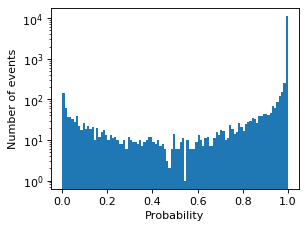

In [240]:
fig, ax = plt.subplots(figsize=(4,3))
ax.hist(
    model_checker_predictions_on_test_df['shower_prob'].iloc[
        learning_data_dict['test']['source_class'].values == EVENT_CLASS_SIMU_TRACK], 
    bins=100, alpha=1, range=(0,1), label='Simu track')
ax.set_ylabel('Number of events')
ax.set_xlabel('Probability')
ax.set_yscale('log')
fig.savefig(os.path.join(data_snippets_dir, 'test_set_simu_track_proba_distribution_horizontal.svg'))
plt.show()

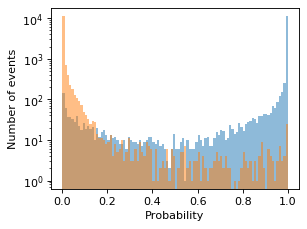

In [243]:
fig, ax = plt.subplots(figsize=(4,3))
ax.hist(
    model_checker_predictions_on_test_df['shower_prob'].iloc[
        learning_data_dict['test']['source_class'].values == EVENT_CLASS_SIMU_TRACK], 
    bins=100, alpha=.5, range=(0,1), label='Simu track')
ax.hist(
    model_checker_predictions_on_test_df['shower_prob'].iloc[
        learning_data_dict['test']['source_class'].values != EVENT_CLASS_SIMU_TRACK], 
    bins=100, alpha=.5, range=(0,1), label='Noise')
ax.set_ylabel('Number of events')
ax.set_xlabel('Probability')
ax.set_yscale('log')
fig.savefig(os.path.join(data_snippets_dir, 'test_set_both_proba_distribution_horizontal.svg'))
plt.show()

#### Cross-validation

In [ ]:
# def cross_val_calc_weights(indices, learning_data__y=learning_data__y, learning_data__source_class=learning_data__source_class): 
#     return calc_learning_data_weights(learning_data__y[indices], learning_data__source_class[indices], print_info=False)

# extra_trees_cls_on_train_rfecv_for_crossvalidation = sklearn.ensemble.ExtraTreesClassifier(**rfe_extra_trees_params)
# # not entirely correct, feature selection should be also included in crossvalidation training

# learning_data__rfecv_var_th_X = \
#     rfecv_selector_on_extra_trees_cls.transform(
#         var_th_selector_on_scaled_train.transform(
#             learning_data__X
#         )
#     )

# extra_trees_cls_on_train_rfecv_for_crossvalidation_crv_results = \
#     cross_val_score_meta_scored(
#         extra_trees_cls_on_train_rfecv_for_crossvalidation, 
#         learning_data__rfecv_var_th_X, learning_data__y, 
#         meta_score_func=None,
#         score_func=balanced_accuracy_score,
#         cv=3, random_state=32, 
#         train_sample_weight_func=cross_val_calc_weights
# )

# print('Cross-validation accuracy:', extra_trees_cls_on_train_rfecv_for_crossvalidation_crv_results)
# print('Mean accuracy:            ', np.mean(extra_trees_cls_on_train_rfecv_for_crossvalidation_crv_results))
# print('Std accuracy:             ', np.std(extra_trees_cls_on_train_rfecv_for_crossvalidation_crv_results))

# extra_trees_cls_on_train_rfecv_for_crossvalidation_lbl_noise_flight_crv_results = \
# cross_val_score_meta_scored(
#     extra_trees_cls_on_train_rfecv_for_crossvalidation,
#     learning_data__rfecv_var_th_X, learning_data__y, 
#     cv=3, random_state=32, verbose=1,
#     meta_score_func=score_masked_using_indices_lbl_noise_flight_mask_arr_all,
#     train_sample_weight_func=cross_val_calc_weights
# )

# print('Cross-validation accuracy (lbl_noise):', extra_trees_cls_on_train_rfecv_for_crossvalidation_lbl_noise_flight_crv_results)
# print('Mean accuracy (lbl_noise):            ', np.mean(extra_trees_cls_on_train_rfecv_for_crossvalidation_lbl_noise_flight_crv_results))
# print('Std accuracy (lbl_noise):             ', np.std(extra_trees_cls_on_train_rfecv_for_crossvalidation_lbl_noise_flight_crv_results))
    

#### Cross-validation of labeled noise data

##### random_state = 123

In [ ]:
# extra_trees_cls_on_train_rfecv_for_crossvalidation_lbl_noise_flight_crv_results_2 = \
# cross_val_score_meta_scored(
#     extra_trees_cls_on_train_rfecv_for_crossvalidation,
#     learning_data__rfecv_var_th_X, learning_data__y, 
#     cv=3, random_state=128, verbose=1,
#     meta_score_func=score_masked_using_indices_lbl_noise_flight_mask_arr_all,
#     train_sample_weight_func=cross_val_calc_weights
# )
# print('Cross-validation accuracy (lbl_noise, seed=123):', extra_trees_cls_on_train_rfecv_for_crossvalidation_lbl_noise_flight_crv_results_2)
# print('Mean accuracy (lbl_noise, seed=123):            ', np.mean(extra_trees_cls_on_train_rfecv_for_crossvalidation_lbl_noise_flight_crv_results_2))
# print('Std accuracy (lbl_noise, seed=123):             ', np.std(extra_trees_cls_on_train_rfecv_for_crossvalidation_lbl_noise_flight_crv_results_2))

## Recognition efficiency

### Test set sensitivity as function of the energy

In [287]:
cnn__test__numbers_by_energy = \
    score_by_column(
        np.round(model_checker_predictions_on_test_df['shower_prob'])[learning_data__simu_shower_track_mask_arr_test].values, 
        None, 
        learning_data_dict['test']['target_class'].values[learning_data__simu_shower_track_mask_arr_test], 
        calc_cls_numbers, #sklearn.metrics.accuracy_score, 
        learning_data_dict['test']['event_id'].values[learning_data__simu_shower_track_mask_arr_test], 
        combined_simu_df, 'etruth_trueenergy')

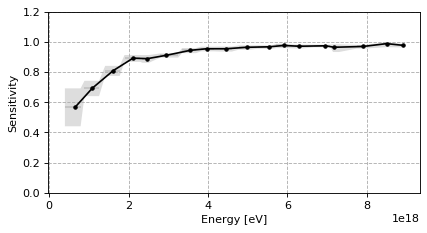

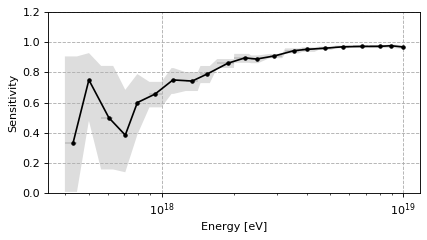

In [289]:
plt.close('all')
for xscale in ('linear', 'log'):
    fig, ax, errbr = \
        plot_efficiency_stat(
            cnn__test__numbers_by_energy, 
            plotted_stat='sensitivity', plotted_yerr_stat='positive_sm_confint_beta_95', num_steps = 20, 
            xscale=xscale, xtranslate_func=lambda l: [v*1e6 for v in l],
            xlabel = 'Energy [eV]', ylabel = 'Sensitivity', 
            calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_with_sm_proportion_confint,
            figsize=(6,3), ylim=(0,1.2), show=False)
    ax.grid(linestyle='--')
    fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                             'test_set_sensitivity_function_of_energy_{}_ev.svg'.format(xscale)), dpi=150)
    plt.show()

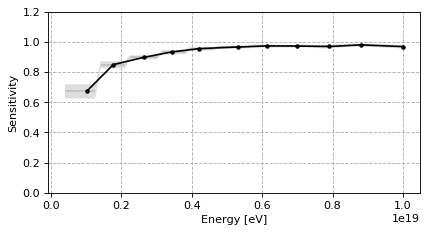

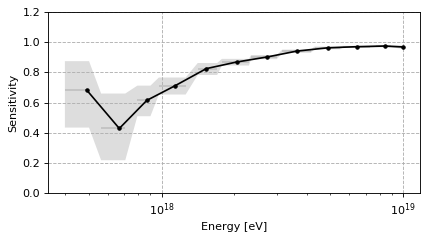

In [293]:
plt.close('all')
for xscale in ('linear', 'log'):
    fig, ax, errbr = \
        plot_efficiency_stat(
            cnn__test__numbers_by_energy, 
            plotted_stat='sensitivity', plotted_yerr_stat='positive_sm_confint_beta_95', num_steps=11, 
            xscale=xscale, xtranslate_func=lambda l: [v*1e6 for v in l],
            xlabel = 'Energy [eV]', ylabel = 'Sensitivity', 
            calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_with_sm_proportion_confint,
            figsize=(6,3), ylim=(0,1.2), show=False)
    ax.grid(linestyle='--')
    fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                             'test_set_sensitivity_function_of_energy_{}_11steps.svg'.format(xscale)), dpi=150)
    plt.show()

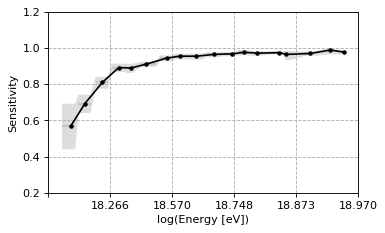

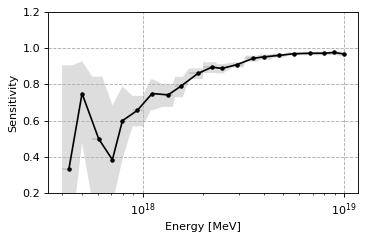

In [294]:
plt.close('all')
for xscale in ( 'linear', 'log', ):
    fig, ax, errbr = \
        plot_efficiency_stat(
            cnn__test__numbers_by_energy, 
            plotted_stat='sensitivity', plotted_yerr_stat='positive_sm_confint_beta_95', num_steps=20, 
            xscale=xscale, xtranslate_func=lambda l: [v*1e6 for v in l],
            xlabel = 'Energy [MeV]', ylabel = 'Sensitivity', 
            calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_with_sm_proportion_confint,
            figsize=(5,3), ylim=(.2,1.2), show=False,
#         show_fill_between=False, show_yerr=True,
#         errorbar_attrs={**EFFICIENCY_STAT_ERRORBAR_DEFAULTS, 'ecolor': 'gray'}
    )
    ax.grid(linestyle='--')
    if xscale == 'linear' :
#         ax.xaxis.set_major_formatter(mpl.ticker.LogFormatterExponent(minor_thresholds=(np.inf, np.inf), labelOnlyBase=False))
        ax.xaxis.set_major_locator(mpl.ticker.LinearLocator(numticks=6))
        ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda v,n: '{:.3f}'.format(np.log10(v)) if v > 0 else '' ))
        ax.set_xlabel('log(Energy [eV])')
        
#     else:
#         ax.set_xscale('symlog')
#         ax.xaxis.set_minor_formatter(mpl.ticker.ExponentFormatter(minor_thresholds=(100, 100), labelOnlyBase=False))
#         ax.xaxis.set_minor_formatter(mpl.ticker.LogFormatterExponent(minor_thresholds=(np.inf, np.inf), labelOnlyBase=False))
#         ax.xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10.0, subs='auto', numdecs=4, numticks='auto'))
        
#         ax.xaxis.set_minor_formatter(mpl.ticker.FuncFormatter(_t_f))

#         mil = ax.xaxis.get_minor_locator()

#         print(dir(mil))
#         print(mil._base)
#         print(mil._subs)
#         print(mil.numdecs)
#         print(mil.numticks)
    
#     plt.close('all')
    
    fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                             'test_set_sensitivity_function_of_energy_{}_20steps.svg'.format(xscale)), dpi=150)
    plt.show()

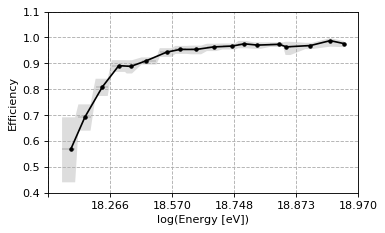

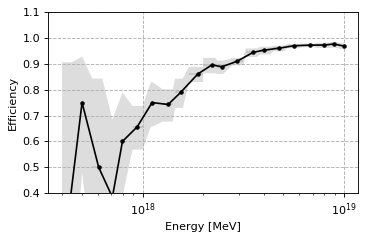

In [295]:
plt.close('all')
for xscale in ( 'linear', 'log', ):
    fig, ax, errbr = \
        plot_efficiency_stat(
            cnn__test__numbers_by_energy, 
            plotted_stat='sensitivity', plotted_yerr_stat='positive_sm_confint_beta_95', num_steps=20, 
            xscale=xscale, xtranslate_func=lambda l: [v*1e6 for v in l],
            xlabel = 'Energy [MeV]', ylabel = 'Efficiency', 
            calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_with_sm_proportion_confint,
            figsize=(5,3), ylim=(.4,1.1), show=False,
#         show_fill_between=False, show_yerr=True,
#         errorbar_attrs={**EFFICIENCY_STAT_ERRORBAR_DEFAULTS, 'ecolor': 'gray'}
    )
    ax.grid(linestyle='--')
    if xscale == 'linear' :
#         ax.xaxis.set_major_formatter(mpl.ticker.LogFormatterExponent(minor_thresholds=(np.inf, np.inf), labelOnlyBase=False))
        ax.xaxis.set_major_locator(mpl.ticker.LinearLocator(numticks=6))
        ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda v,n: '{:.3f}'.format(np.log10(v)) if v > 0 else '' ))
        ax.set_xlabel('log(Energy [eV])')
        
#     else:
#         ax.set_xscale('symlog')
#         ax.xaxis.set_minor_formatter(mpl.ticker.ExponentFormatter(minor_thresholds=(100, 100), labelOnlyBase=False))
#         ax.xaxis.set_minor_formatter(mpl.ticker.LogFormatterExponent(minor_thresholds=(np.inf, np.inf), labelOnlyBase=False))
#         ax.xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10.0, subs='auto', numdecs=4, numticks='auto'))
        
#         ax.xaxis.set_minor_formatter(mpl.ticker.FuncFormatter(_t_f))

#         mil = ax.xaxis.get_minor_locator()

#         print(dir(mil))
#         print(mil._base)
#         print(mil._subs)
#         print(mil.numdecs)
#         print(mil.numticks)
    
#     plt.close('all')
    
    fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                             'test_set_sensitivity_function_of_energy_{}_20steps_efficiency_range_04_11.svg'.format(xscale)), dpi=150)
    plt.show()

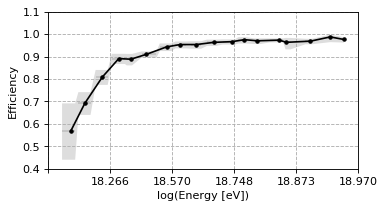

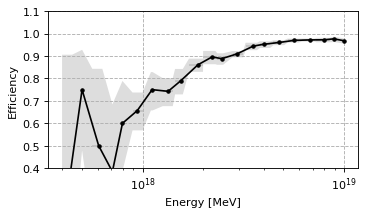

In [296]:
plt.close('all')
for xscale in ( 'linear', 'log', ):
    fig, ax, errbr = \
        plot_efficiency_stat(
            cnn__test__numbers_by_energy, 
            plotted_stat='sensitivity', plotted_yerr_stat='positive_sm_confint_beta_95', num_steps=20, 
            xscale=xscale, xtranslate_func=lambda l: [v*1e6 for v in l],
            xlabel = 'Energy [MeV]', ylabel = 'Efficiency', 
            calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_with_sm_proportion_confint,
            figsize=(5,2.6), ylim=(.4,1.1), show=False,
#         show_fill_between=False, show_yerr=True,
#         errorbar_attrs={**EFFICIENCY_STAT_ERRORBAR_DEFAULTS, 'ecolor': 'gray'}
    )
    ax.grid(linestyle='--')
    if xscale == 'linear' :
#         ax.xaxis.set_major_formatter(mpl.ticker.LogFormatterExponent(minor_thresholds=(np.inf, np.inf), labelOnlyBase=False))
        ax.xaxis.set_major_locator(mpl.ticker.LinearLocator(numticks=6))
        ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda v,n: '{:.3f}'.format(np.log10(v)) if v > 0 else '' ))
        ax.set_xlabel('log(Energy [eV])')
        
#     else:
#         ax.set_xscale('symlog')
#         ax.xaxis.set_minor_formatter(mpl.ticker.ExponentFormatter(minor_thresholds=(100, 100), labelOnlyBase=False))
#         ax.xaxis.set_minor_formatter(mpl.ticker.LogFormatterExponent(minor_thresholds=(np.inf, np.inf), labelOnlyBase=False))
#         ax.xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10.0, subs='auto', numdecs=4, numticks='auto'))
        
#         ax.xaxis.set_minor_formatter(mpl.ticker.FuncFormatter(_t_f))

#         mil = ax.xaxis.get_minor_locator()

#         print(dir(mil))
#         print(mil._base)
#         print(mil._subs)
#         print(mil.numdecs)
#         print(mil.numticks)
    
#     plt.close('all')
    
    fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                             'test_set_sensitivity_function_of_energy_{}_20steps_efficiency_range_04_11_h26.svg'.format(xscale)), dpi=150)
    plt.show()

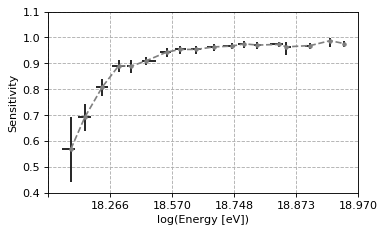

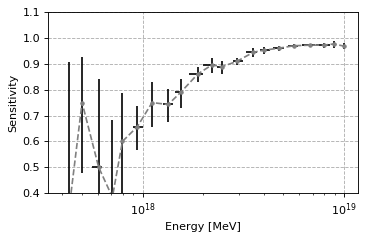

In [298]:
plt.close('all')
for xscale in ( 'linear', 'log', ):
    fig, ax, errbr = \
        plot_efficiency_stat(
            cnn__test__numbers_by_energy, 
            plotted_stat='sensitivity', plotted_yerr_stat='positive_sm_confint_beta_95', num_steps=20, 
            xscale=xscale, xtranslate_func=lambda l: [v*1e6 for v in l],
            xlabel = 'Energy [MeV]', ylabel = 'Sensitivity', 
            calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_with_sm_proportion_confint,
            figsize=(5,3), ylim=(.4,1.1), show=False,
            show_fill_between=False, show_yerr=True,
            errorbar_attrs={**EFFICIENCY_STAT_ERRORBAR_DEFAULTS, 'ecolor': '#000000', 'linestyle': '--', 'color': 'gray'}
    )
    ax.grid(linestyle='--')
    if xscale == 'linear' :
#         ax.xaxis.set_major_formatter(mpl.ticker.LogFormatterExponent(minor_thresholds=(np.inf, np.inf), labelOnlyBase=False))
        ax.xaxis.set_major_locator(mpl.ticker.LinearLocator(numticks=6))
        ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda v,n: '{:.3f}'.format(np.log10(v)) if v > 0 else '' ))
        ax.set_xlabel('log(Energy [eV])')
        
#     else:
#         ax.set_xscale('symlog')
#         ax.xaxis.set_minor_formatter(mpl.ticker.ExponentFormatter(minor_thresholds=(100, 100), labelOnlyBase=False))
#         ax.xaxis.set_minor_formatter(mpl.ticker.LogFormatterExponent(minor_thresholds=(np.inf, np.inf), labelOnlyBase=False))
#         ax.xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10.0, subs='auto', numdecs=4, numticks='auto'))
        
#         ax.xaxis.set_minor_formatter(mpl.ticker.FuncFormatter(_t_f))

#         mil = ax.xaxis.get_minor_locator()

#         print(dir(mil))
#         print(mil._base)
#         print(mil._subs)
#         print(mil.numdecs)
#         print(mil.numticks)
    
#     plt.close('all')
    
    fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                             'test_set_sensitivity_function_of_energy_{}_20steps_range_04_11_errbars.svg'.format(xscale)), dpi=150)
    plt.show()

(-2.761315e+16, 9.33823015e+18)


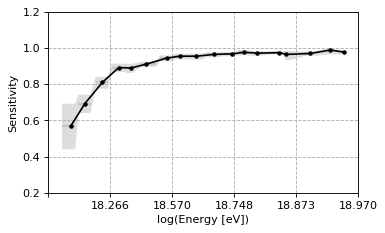

In [301]:
plt.close('all')
for xscale in ( 'linear',  ): #'log',
    fig, ax, errbr = \
        plot_efficiency_stat(
            cnn__test__numbers_by_energy, 
            plotted_stat='sensitivity', plotted_yerr_stat='positive_sm_confint_beta_95', num_steps=20, 
            xscale=xscale, xtranslate_func=lambda l: [v*1e6 for v in l],
            xlabel = 'Energy [MeV]', ylabel = 'Sensitivity', 
            calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_with_sm_proportion_confint,
            figsize=(5,3), ylim=(.2,1.2), show=False,
#         show_fill_between=False, show_yerr=True,
#         errorbar_attrs={**EFFICIENCY_STAT_ERRORBAR_DEFAULTS, 'ecolor': 'gray'}
    )
    ax.grid(linestyle='--')
    if xscale == 'linear' :
#         ax.xaxis.set_major_formatter(mpl.ticker.LogFormatterExponent(minor_thresholds=(np.inf, np.inf), labelOnlyBase=False))
        ax.xaxis.set_major_locator(mpl.ticker.LinearLocator(numticks=6))
        ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda v,n: '{:.3f}'.format(np.log10(v)) if v > 0 else '' ))
        ax.set_xlabel('log(Energy [eV])')
        
        print(ax.get_xlim())
        print(ax.xaxis.get_major_locator())
        
#     else:
#         ax.set_xscale('symlog')
#         ax.xaxis.set_minor_formatter(mpl.ticker.ExponentFormatter(minor_thresholds=(100, 100), labelOnlyBase=False))
#         ax.xaxis.set_minor_formatter(mpl.ticker.LogFormatterExponent(minor_thresholds=(np.inf, np.inf), labelOnlyBase=False))
#         ax.xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10.0, subs='auto', numdecs=4, numticks='auto'))
        
#         ax.xaxis.set_minor_formatter(mpl.ticker.FuncFormatter(_t_f))

#         mil = ax.xaxis.get_minor_locator()

#         print(dir(mil))
#         print(mil._base)
#         print(mil._subs)
#         print(mil.numdecs)
#         print(mil.numticks)
    
#     plt.close('all')
    
#     fig.savefig(os.path.join(data_snippets_dir, 'figures', 
#                              'test_set_sensitivity_function_of_energy_{}_20steps.svg'.format(xscale)), dpi=150)
    plt.show()

popt:
 [-0.711121950914029, 8.831514852131931e-19, 0.9717206794010561]
pcov:
 [[ 5.69725657e-03 -5.14222989e-21  1.69076127e-04]
 [-5.14222989e-21  5.96724102e-39 -3.02867487e-22]
 [ 1.69076127e-04 -3.02867487e-22  3.33193070e-05]]


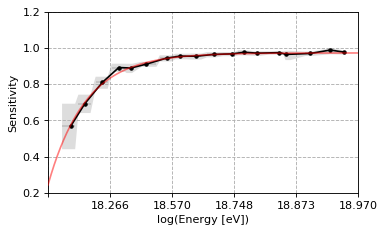

In [307]:
plt.close('all')
fig, ax, errbr = \
    plot_efficiency_stat(
        cnn__test__numbers_by_energy, 
        plotted_stat='sensitivity', plotted_yerr_stat='positive_sm_confint_beta_95', num_steps=20, 
        xscale='linear', xtranslate_func=lambda l: [v*1e6 for v in l],
        xlabel = 'Energy [MeV]', ylabel = 'Sensitivity', 
        calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_with_sm_proportion_confint,
        figsize=(5,3), ylim=(.2,1.2), show=False,
#         show_fill_between=False, show_yerr=True,
#         errorbar_attrs={**EFFICIENCY_STAT_ERRORBAR_DEFAULTS, 'ecolor': 'gray'}
)

ax.grid(linestyle='--')
# ax.xaxis.set_major_formatter(mpl.ticker.LogFormatterExponent(minor_thresholds=(np.inf, np.inf), labelOnlyBase=False))
ax.xaxis.set_major_locator(mpl.ticker.LinearLocator(numticks=6))
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda v,n: '{:.3f}'.format(np.log10(v)) if v > 0 else '' ))
ax.set_xlabel('log(Energy [eV])')

plot_x, plot_y, plot_xerr, plot_yerr = \
    get_efficiency_stat_plot_data(cnn__test__numbers_by_energy, 
                             plotted_stat='sensitivity', plotted_yerr_stat='positive_sm_confint_beta_95', num_steps = 10, 
#                              xtranslate_func=lambda l: [v*1e6 for v in l],
                             calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_with_sm_proportion_confint)

def fit_func(x, A,B,C): 
    return A*np.exp(-B*x) + C

plot_x = np.array(plot_x) * 1e6

popt, pcov = sp_opt.curve_fit(fit_func, plot_x, plot_y, method='lm', p0=(-0.56, 0.965/1e18, 0.965), 
                              sigma=np.array(plot_yerr[1])-plot_yerr[0])
print('popt:\n', popt.tolist())
print('pcov:\n', pcov)

orig_lim = ax.get_xlim()

func_plt_x = np.linspace(*orig_lim,100)
func_plt_y = fit_func(func_plt_x, *popt)

# func_plt_y_simple = fit_func(func_plt_x, -0.927, 1.123e-18, 0.96)


# print(func_plt_x)
# print(func_plt_y)

# f,ax = plt.subplots()
ax.plot(func_plt_x, func_plt_y, 'r', alpha=0.5, zorder=10)
# ax.plot(func_plt_x, func_plt_y_simple, 'b', alpha=0.5, zorder=10)


ax.set_xlim(*orig_lim)
# ax.set_ylim(0.8,1)

fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                         'test_set_sensitivity_function_of_energy_linear_20steps_fitted.svg'), dpi=150)
plt.show()

In [314]:
# http://specminor.org/2017/01/08/performing-chi-squared-gof-python.html
import scipy, scipy.stats

plot_y_fit = fit_func(plot_x, *popt)

print('plot_y    ', np.round(plot_y, 3))
print('plot_y_fit', np.round(plot_y_fit, 3))
print(scipy.stats.chisquare(plot_y, f_exp=plot_y_fit))

plot_y     [0.672 0.856 0.904 0.949 0.959 0.97  0.972 0.968 0.979]
plot_y_fit [0.683 0.839 0.913 0.946 0.961 0.967 0.97  0.971 0.971]
Power_divergenceResult(statistic=0.0006822393906419839, pvalue=0.9999999999999994)


### Number of true positivie and positive samples as function of the energy

#### Number of positive samples as function of the energy

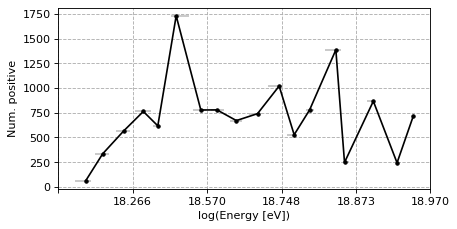

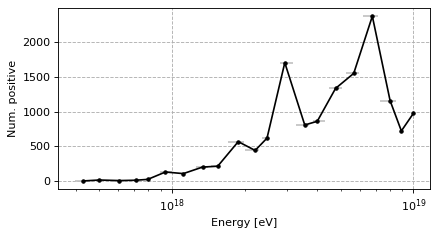

In [316]:
for xscale in ('linear', 'log'):
    fig, ax, errbr = \
        plot_efficiency_stat(cnn__test__numbers_by_energy, 
                             plotted_stat='num_positive', num_steps = 20, 
                             xscale=xscale, xtranslate_func=lambda l: [v*1e6 for v in l],
                             xlabel = 'Energy [eV]', ylabel = 'Num. positive', 
                             figsize =(6,3), show=False)

    ax.grid(linestyle='--')
    if xscale == 'linear' :
#         ax.xaxis.set_major_formatter(mpl.ticker.LogFormatterExponent(minor_thresholds=(np.inf, np.inf), labelOnlyBase=False))
        ax.xaxis.set_major_locator(mpl.ticker.LinearLocator(numticks=6))
        ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda v,n: '{:.3f}'.format(np.log10(v)) if v > 0 else '' ))
        ax.set_xlabel('log(Energy [eV])')
        
    fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                             'Number of positive samples as function of the energy - {}.svg'.format(xscale)), dpi=150)
    plt.show()
    

##### Number of true positive samples as function of the energy

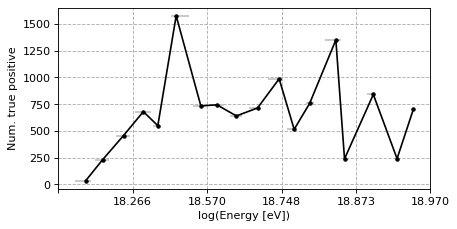

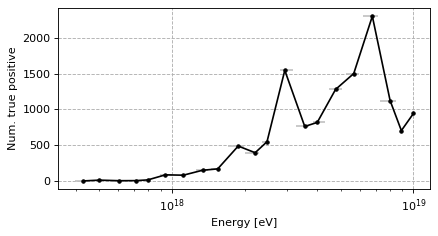

In [317]:
for xscale in ('linear', 'log'):
    fig, ax, errbr = \
        plot_efficiency_stat(cnn__test__numbers_by_energy, 
                             plotted_stat='num_true_positive', num_steps = 20, 
                             xscale=xscale, xtranslate_func=lambda l: [v*1e6 for v in l],
                             xlabel = 'Energy [eV]', ylabel = 'Num. true positive', 
                             figsize = (6,3), show=False)
    ax.grid(linestyle='--')
    if xscale == 'linear' :
        ax.xaxis.set_major_locator(mpl.ticker.LinearLocator(numticks=6))
        ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda v,n: '{:.3f}'.format(np.log10(v)) if v > 0 else '' ))
#         ax.xaxis.set_major_formatter(mpl.ticker.LogFormatterExponent(minor_thresholds=(np.inf, np.inf), labelOnlyBase=False))
        ax.set_xlabel('log(Energy [eV])')
    fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                             'Number of true positive samples as function of the energy - {}.svg'.format(xscale)), dpi=150)
    plt.show()

##### Number of true positive or positive samples as function of the energy - comparison

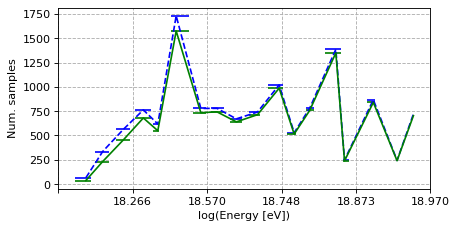

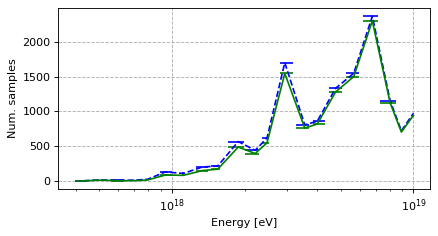

In [319]:
plt.close('all')
for xscale in ('linear', 'log'):
    fig, ax = plt.subplots()
    fig, ax, errbr_num_positive = \
        plot_efficiency_stat(
            cnn__test__numbers_by_energy, 
            plotted_stat='num_positive', num_steps = 20, xscale=xscale, xtranslate_func=lambda l: [v*1e6 for v in l],
            xlabel = 'Energy [eV]', ylabel = 'Num. positive', label='Num. positive',
            figsize = (6,3), errorbar_attrs=dict(linestyle='--', color='blue'), 
            ax=ax, show=False)
    fig, ax, errbr_num_true_positive = \
        plot_efficiency_stat(
            cnn__test__numbers_by_energy, 
            plotted_stat='num_true_positive', num_steps = 20, xscale=xscale, xtranslate_func=lambda l: [v*1e6 for v in l],
            xlabel='Energy [eV]', ylabel = 'Num. true positive', label='Num. true positive',
            figsize=(6,3), errorbar_attrs=dict(linestyle='-', color='green'),
            ax=ax, show=False)
    ax.set_ylabel('Num. samples')
    ax.grid(linestyle='--')
    if xscale == 'linear' :
        ax.xaxis.set_major_locator(mpl.ticker.LinearLocator(numticks=6))
        ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda v,n: '{:.3f}'.format(np.log10(v)) if v > 0 else '' ))
#         ax.xaxis.set_major_formatter(mpl.ticker.LogFormatterExponent(minor_thresholds=(np.inf, np.inf), labelOnlyBase=False))
        ax.set_xlabel('log(Energy [eV])')
    ax.grid(linestyle='--')
    fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                             'Number of true positive or positive samples as function of the energy - comparison - {}.svg'.format(xscale)), dpi=150)
    plt.show()

#### Test set sensitivity as function of the theta (zenith angle)

In [320]:
cnn__test__numbers_by_theta = \
    score_by_column(
        np.round(model_checker_predictions_on_test_df['shower_prob'])[learning_data__simu_shower_track_mask_arr_test].values, 
        None, 
        learning_data_dict['test']['target_class'].values[learning_data__simu_shower_track_mask_arr_test], 
        calc_cls_numbers, #sklearn.metrics.accuracy_score, 
        learning_data_dict['test']['event_id'].values[learning_data__simu_shower_track_mask_arr_test], 
        combined_simu_df, 'etruth_truetheta')

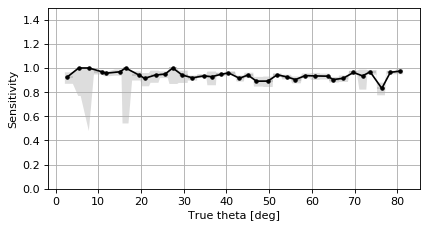

In [321]:
fig, ax, errbr = \
    plot_efficiency_stat(cnn__test__numbers_by_theta, 
                         plotted_stat='sensitivity', plotted_yerr_stat='positive_sm_confint_beta_95', num_steps = 90/2.5, 
                         xtranslate_func=np.rad2deg,
                         xlabel ='True theta [deg]', ylabel = 'Sensitivity', 
                         calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_with_sm_proportion_confint,
                         figsize = (6,3), ylim=(0,1.5), show=False)
ax.grid()
fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                         'test_set_sensitivity_function_of_theta.svg'), dpi=150)
plt.show()

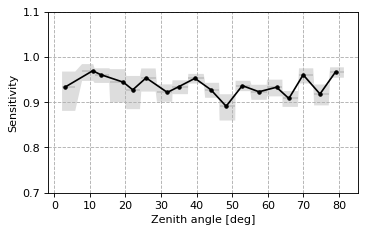

In [322]:
fig, ax, errbr = \
    plot_efficiency_stat(cnn__test__numbers_by_theta, 
                         plotted_stat='sensitivity', plotted_yerr_stat='positive_sm_confint_beta_95', num_steps = 90/5, 
                         xtranslate_func=np.rad2deg,
                         xlabel ='Zenith angle [deg]', ylabel = 'Sensitivity', 
                         calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_with_sm_proportion_confint,
                         figsize = (5,3), ylim=(0.7,1.1), show=False,
                        )
ax.grid(linestyle='--')
fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                         'test_set_sensitivity_function_of_theta_5deg.svg'), dpi=150)
plt.show()

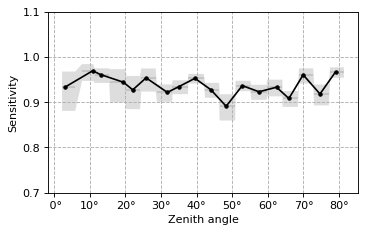

In [323]:
fig, ax, errbr = \
    plot_efficiency_stat(cnn__test__numbers_by_theta, 
                         plotted_stat='sensitivity', plotted_yerr_stat='positive_sm_confint_beta_95', num_steps = 90/5, 
                         xtranslate_func=np.rad2deg,
                         xlabel ='Zenith angle', ylabel = 'Sensitivity', 
                         calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_with_sm_proportion_confint,
                         figsize = (5,3), ylim=(0.7,1.1), show=False,
                        )
ax.grid(linestyle='--')
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:2.0f}°'))
fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                         'test_set_sensitivity_function_of_theta_5deg_formatter.svg'), dpi=150)
plt.show()

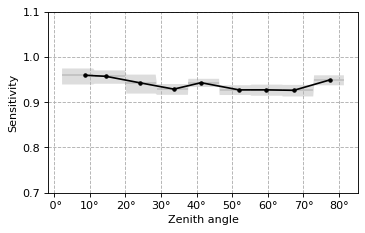

In [324]:
fig, ax, errbr = \
    plot_efficiency_stat(cnn__test__numbers_by_theta, 
                         plotted_stat='sensitivity', plotted_yerr_stat='positive_sm_confint_beta_95', num_steps = 90/10, 
                         xtranslate_func=np.rad2deg,
                         xlabel ='Zenith angle', ylabel = 'Sensitivity', 
                         calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_with_sm_proportion_confint,
                         figsize = (5,3), ylim=(0.7,1.1), show=False,
                        )
ax.grid(linestyle='--')
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:2.0f}°'))
fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                         'test_set_sensitivity_function_of_theta_10deg_formatter.svg'), dpi=150)
plt.show()

#### Test set sensitivity as function of the phi (azimuth angle)

In [325]:
cnn__test__numbers_by_phi = \
    score_by_column(
        np.round(model_checker_predictions_on_test_df['shower_prob'])[learning_data__simu_shower_track_mask_arr_test].values, 
        None, 
        learning_data_dict['test']['target_class'].values[learning_data__simu_shower_track_mask_arr_test], 
        calc_cls_numbers, #sklearn.metrics.accuracy_score, 
        learning_data_dict['test']['event_id'].values[learning_data__simu_shower_track_mask_arr_test], 
        combined_simu_df, 'etruth_truephi')

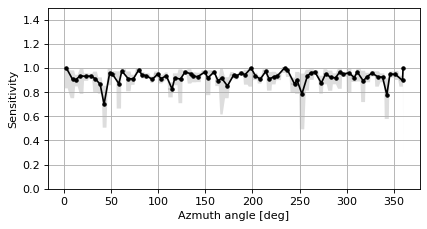

In [326]:
fig, ax, errbr = \
    plot_efficiency_stat(cnn__test__numbers_by_phi, 
                         plotted_stat='sensitivity', plotted_yerr_stat='positive_sm_confint_beta_95', num_steps = 360/5, 
                         xtranslate_func=np.rad2deg,
                         xlabel = 'Azmuth angle [deg]', ylabel = 'Sensitivity', 
                         calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_with_sm_proportion_confint,
                         figsize = (6,3), ylim=(0,1.5), show=False)
ax.grid()
fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                         'test_set_sensitivity_function_of_phi_10deg_5deg.svg'), dpi=150)
plt.show()

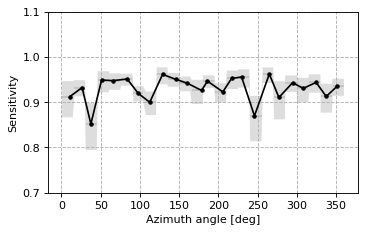

In [327]:
fig, ax, errbr = \
    plot_efficiency_stat(cnn__test__numbers_by_phi, 
                         plotted_stat='sensitivity', plotted_yerr_stat='positive_sm_confint_beta_95', num_steps = 360/15, 
                         xtranslate_func=np.rad2deg,
                         xlabel = 'Azimuth angle [deg]', ylabel = 'Sensitivity', 
                         calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_with_sm_proportion_confint,
                         figsize = (5,3), ylim=(0.7,1.1), show=False)
ax.grid(linestyle='--')
fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                         'test_set_sensitivity_function_of_phi_15deg.svg'), dpi=150)
plt.show()

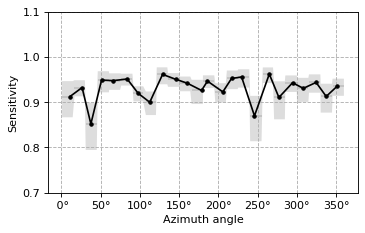

In [328]:
fig, ax, errbr = \
    plot_efficiency_stat(cnn__test__numbers_by_phi, 
                         plotted_stat='sensitivity', plotted_yerr_stat='positive_sm_confint_beta_95', num_steps = 360/15, 
                         xtranslate_func=np.rad2deg,
                         xlabel = 'Azimuth angle', ylabel = 'Sensitivity', 
                         calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_with_sm_proportion_confint,
                         figsize = (5,3), ylim=(0.7,1.1), show=False)
ax.grid(linestyle='--')
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:2.0f}°'))
fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                         'test_set_sensitivity_function_of_phi_15deg_formatter.svg'), dpi=150)
plt.show()

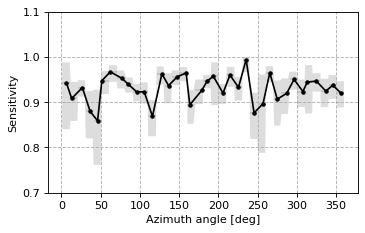

In [329]:
fig, ax, errbr = \
    plot_efficiency_stat(cnn__test__numbers_by_phi, 
                         plotted_stat='sensitivity', plotted_yerr_stat='positive_sm_confint_beta_95', num_steps = 360/10, 
                         xtranslate_func=np.rad2deg,
                         xlabel = 'Azimuth angle [deg]', ylabel = 'Sensitivity', 
                         calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_with_sm_proportion_confint,
                         figsize = (5,3), ylim=(0.7,1.1), show=False)
ax.grid(linestyle='--')
fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                         'test_set_sensitivity_function_of_phi_10deg.svg'), dpi=150)
plt.show()

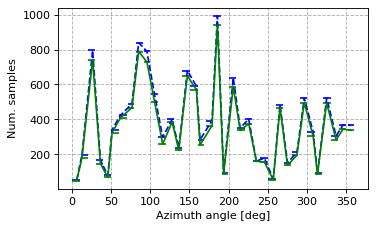

In [330]:
plt.close('all')
fig, ax = plt.subplots()
fig, ax, errbr_num_positive = \
    plot_efficiency_stat(
        cnn__test__numbers_by_phi, 
        plotted_stat='num_positive', num_steps = 360/10, 
        xtranslate_func=np.rad2deg,
        xlabel = 'Azimuth angle [deg]', ylabel = 'Num. positive', label='Num. positive',
        figsize = (5,3), errorbar_attrs=dict(linestyle='--', color='blue'), 
        ax=ax, show=False)
fig, ax, errbr_num_true_positive = \
    plot_efficiency_stat(
        cnn__test__numbers_by_phi, 
        plotted_stat='num_true_positive', num_steps = 360/10, 
        xtranslate_func=np.rad2deg,
        xlabel='Azimuth angle [deg]', ylabel = 'Num. true positive', label='Num. true positive',
        figsize=(5,3), errorbar_attrs=dict(linestyle='-', color='green'),
        ax=ax, show=False)
ax.set_ylabel('Num. samples')
ax.grid(linestyle='--')
fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                         'test_set_num_positive_function_of_phi_comparison_10deg_{}.svg'.format(xscale)), dpi=150)
plt.show()

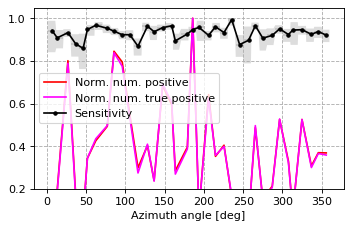

In [333]:
plt.close('all')

fig, ax, errbr = \
    plot_efficiency_stat(cnn__test__numbers_by_phi, 
                         plotted_stat='sensitivity', plotted_yerr_stat='positive_sm_confint_beta_95', num_steps = 360/10, 
                         xtranslate_func=np.rad2deg,
                         xlabel = 'Azimuth angle [deg]', ylabel = 'Sensitivity', label='Sensitivity',
                         calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_with_sm_proportion_confint,
                         figsize = (5,3), ylim=(0.7,1.1), show=False)


plot_x, plot_y, plot_xerr, plot_yerr = \
    get_efficiency_stat_plot_data(
        cnn__test__numbers_by_phi, 
        plotted_stat='num_positive', num_steps = 360/10, 
        xtranslate_func=np.rad2deg)

ax.plot(plot_x, plot_y/max(plot_y), color='red', label='Norm. num. positive')

plot_x, plot_y, plot_xerr, plot_yerr = \
    get_efficiency_stat_plot_data(
        cnn__test__numbers_by_phi, 
        plotted_stat='num_true_positive', num_steps = 360/10, 
        xtranslate_func=np.rad2deg)
ax.plot(plot_x, plot_y/max(plot_y), color='magenta', label='Norm. num. true positive')
        
ax.set_ylim(0.2, 1.05)        
ax.set_ylabel('')
ax.grid(linestyle='--')
ax.legend()

fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                         'test_set_num_positive_function_of_phi_comparison_w_phi_10deg_{}.svg'.format(xscale)), dpi=150)
plt.show()

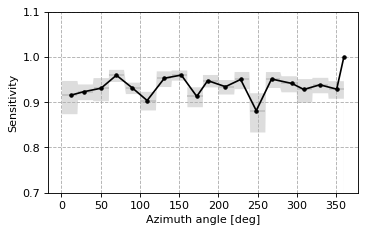

In [334]:
fig, ax, errbr = \
    plot_efficiency_stat(cnn__test__numbers_by_phi, 
                         plotted_stat='sensitivity', plotted_yerr_stat='positive_sm_confint_beta_95', num_steps = 360/20, 
                         xtranslate_func=np.rad2deg,
                         xlabel = 'Azimuth angle [deg]', ylabel = 'Sensitivity', 
                         calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_with_sm_proportion_confint,
                         figsize = (5,3), ylim=(0.7,1.1), show=False)
ax.grid(linestyle='--')
fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                         'test_set_sensitivity_function_of_phi_20deg.svg'), dpi=150)
plt.show()

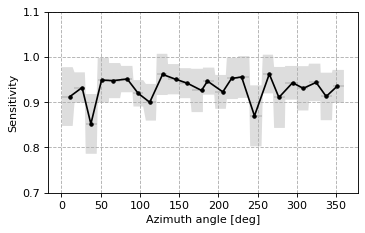

In [335]:
fig, ax, errbr = \
    plot_efficiency_stat(cnn__test__numbers_by_phi, 
                         plotted_stat='sensitivity', plotted_yerr_stat='sensitivity_err_mario', num_steps = 360/15, 
                         xtranslate_func=np.rad2deg,
                         xlabel = 'Azimuth angle [deg]', ylabel = 'Sensitivity', 
                         calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_with_sm_proportion_confint,
                         figsize = (5,3), ylim=(0.7,1.1), show=False)
ax.grid(linestyle='--')
fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                         'test_set_sensitivity_function_of_phi_15deg_sensitivity_err_mario.svg'), dpi=150)
plt.show()

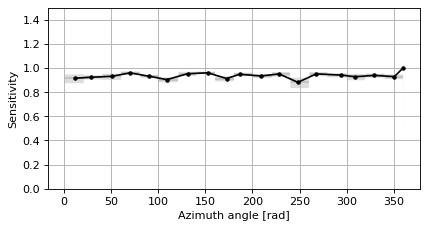

In [336]:
fig, ax, errbr = \
    plot_efficiency_stat(cnn__test__numbers_by_phi, 
                         plotted_stat='sensitivity', plotted_yerr_stat='positive_sm_confint_beta_95', num_steps = 360/20, 
                         xtranslate_func=np.rad2deg,
                         xlabel = 'Azimuth angle [rad]', ylabel = 'Sensitivity', 
                         calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_with_sm_proportion_confint,
                         figsize = (6,3), ylim=(0,1.5), show=False)
ax.grid()
fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                         'test_set_sensitivity_function_of_phi_20deg_far.svg'), dpi=150)
plt.show()

#### Test set sensitivity as function of the $R_\textrm{max}$

In [337]:
cnn__test__numbers_by_rmax = \
    score_by_column(
        np.round(model_checker_predictions_on_test_df['shower_prob'])[learning_data__simu_shower_track_mask_arr_test].values, 
        None, 
        learning_data_dict['test']['target_class'].values[learning_data__simu_shower_track_mask_arr_test], 
        calc_cls_numbers, #sklearn.metrics.accuracy_score, 
        learning_data_dict['test']['event_id'].values[learning_data__simu_shower_track_mask_arr_test], 
        combined_simu_df, 'calc_etruth_trueshower_rmax')

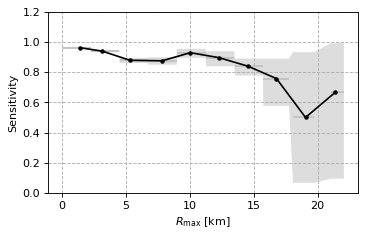

In [341]:
fig, ax, errbr = \
    plot_efficiency_stat(cnn__test__numbers_by_rmax, 
                         plotted_stat='sensitivity', plotted_yerr_stat='positive_sm_confint_beta_95', num_steps = 10, 
                         xtranslate_func=lambda l: [v/1e6 for v in l],
                         xlabel = '$R_\mathrm{max}$ [km]', ylabel = 'Sensitivity', 
                         calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_with_sm_proportion_confint,
                         figsize = (5,3), ylim=(0,1.2), show=False,
                         filter_max_yerr=0.9
#                          show_fill_between=False, show_yerr=True
                        )
ax.grid(linestyle='--')
fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                         'test_set_sensitivity_function_of_rmax_10steps.svg'), dpi=150)
plt.show()

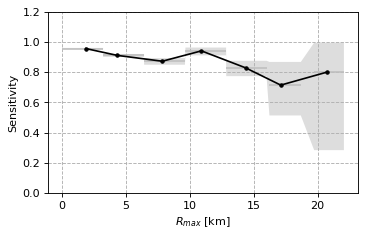

In [343]:
fig, ax, errbr = \
    plot_efficiency_stat(cnn__test__numbers_by_rmax, 
                         plotted_stat='sensitivity', plotted_yerr_stat='positive_sm_confint_beta_95', num_steps = 7, 
                         xtranslate_func=lambda l: [v/1e6 for v in l],
                         xlabel = '$R_{max}$ [km]', ylabel = 'Sensitivity', 
                         calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_with_sm_proportion_confint,
                         figsize = (5,3), ylim=(0,1.2), show=False)
ax.grid(linestyle='--')
fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                         'test_set_sensitivity_function_of_rmax_7steps.svg'), dpi=150)
plt.show()

#### Test set sensitivity as function of the air shower track visibility

In [344]:
cnn__test__numbers_by_visibility = \
    score_by_column(
        np.round(model_checker_predictions_on_test_df['shower_prob'])[learning_data__simu_shower_track_mask_arr_test].values, 
        None, 
        learning_data_dict['test']['target_class'].values[learning_data__simu_shower_track_mask_arr_test], 
        calc_cls_numbers, #sklearn.metrics.accuracy_score, 
        learning_data_dict['test']['event_id'].values[learning_data__simu_shower_track_mask_arr_test], 
        combined_simu_df, 'num_frames_signals_ge_bg')

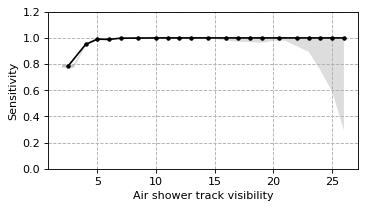

In [345]:
plt.close('all')
for xscale in ('linear', ):
    fig, ax, errbr = \
        plot_efficiency_stat(
            cnn__test__numbers_by_visibility, 
            plotted_stat='sensitivity', plotted_yerr_stat='positive_sm_confint_beta_95', num_steps = 20, 
            xscale=xscale, xtranslate_func=None,
            xlabel = 'Air shower track visibility', ylabel = 'Sensitivity', 
            calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_with_sm_proportion_confint,
            figsize=(5,2.6), ylim=(0,1.2), show=False)
    ax.grid(linestyle='--')
    fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                             'test_set_sensitivity_function_of_num_frames_signals_ge_bg_{}_ev.svg'.format(xscale)), dpi=150)
    plt.show()

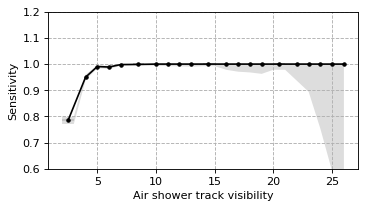

In [346]:
plt.close('all')
for xscale in ('linear', ):
    fig, ax, errbr = \
        plot_efficiency_stat(
            cnn__test__numbers_by_visibility, 
            plotted_stat='sensitivity', plotted_yerr_stat='positive_sm_confint_beta_95', num_steps = 20, 
            xscale=xscale, xtranslate_func=None,
            xlabel = 'Air shower track visibility', ylabel = 'Sensitivity', 
            calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_with_sm_proportion_confint,
            figsize=(5,2.6), ylim=(0.6,1.2), show=False)
    ax.grid(linestyle='--')
    fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                             'test_set_sensitivity_function_of_num_frames_signals_ge_bg_{}_ev__ylim_06_12.svg'.format(xscale)), dpi=150)
    plt.show()

### Cross-validated recognition performance

In [ ]:
# TODO

# extra_trees_cls_on_train_rfecv_for_crossvalidation_per_trueenergy_results = \
#     cross_val_score_meta_scored(
    
#         extra_trees_cls_on_train_rfecv_for_crossvalidation, 
#         learning_data__rfecv_var_th_X, learning_data__y, 
#         meta_score_func=None,
#         score_func=calc_cls_numbers,
#         cv=3, random_state=32, 
#         train_sample_weight_func=cross_val_calc_weights
    
    
    
    
    
#         extra_trees_cls_on_train_rfecv_for_crossvalidation,
#         learning_data__rfecv_var_th_X, learning_data__y,
#         get_func_score_by_column_using_indices(None, learning_data__event_id, combined_simu_df, 'etruth_trueenergy'),
#         score_func=calc_cls_numbers,
#         cv=sklearn.model_selection.RepeatedKFold(n_splits=5, n_repeats=10, random_state=123), verbose=1
#     )

#### Considering all samples from cross-validations (not very correct)
All results from the cross-validations are joined into a single set (list) and then this set is used to calculate error - this multiplies size of the dataset by number of cross-validation folds.

Functions are not using any results reduce function - parameter `dict_stats_yerr_reduce` is not set.

In [ ]:
# plt.close('all')
# for xscale in ['linear', 'log']:
#     fig, ax, errbr = \
#         plot_efficiency_stat(extra_trees_cls_on_train_rfecv_for_crossvalidation_per_trueenergy_results, 
#                              plotted_stat='sensitivity', plotted_yerr_stat='positive_sm_confint_beta_95', num_steps = 20, xscale=xscale,
#                              calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_with_sm_proportion_confint,
#                              xlabel = 'True energy [MeV]', ylabel = 'Sensitivity', 
#                              figsize = (10,6), ylim=(0,1.2), show=False)
#     fig.savefig(os.path.join(data_snippets_dir, 'figures', 
#                              'Cross-validated - Considering all samples from cross-validations (not very correct) - sensitivity - {}.svg'.format(xscale)), dpi=150)
# for xscale in ['linear', 'log']: 
#     fig, ax = plt.subplots()
#     fig, ax, errbr_num_positive = \
#         plot_efficiency_stat(
#             extra_trees_cls_on_train_rfecv_for_crossvalidation_per_trueenergy_results, 
#             plotted_stat='num_positive', num_steps = 20, xscale=xscale,
#             xlabel = 'True energy [MeV]', ylabel = 'Num. positive', label='Num. positive',
#             figsize = (10,6), errorbar_attrs=dict(linestyle='-', color='blue'),
#             ax=ax, show=False)
#     fig, ax, errbr_num_true_positive = \
#         plot_efficiency_stat(
#             extra_trees_cls_on_train_rfecv_for_crossvalidation_per_trueenergy_results, 
#             plotted_stat='num_true_positive', num_steps = 20, xscale=xscale,
#             xlabel='True energy [MeV]', ylabel = 'Num. true positive', label='Num. true positive',
#             figsize=(10,6), errorbar_attrs=dict(linestyle='-', color='green'),
#             ax=ax, show=False)
#     ax.set_ylabel('Num. samples')
#     ax.legend()
#     fig.savefig(os.path.join(data_snippets_dir, 'figures', 
#                              'Cross-validated - Considering all samples from cross-validations (not very correct) - num samples - {}.svg'.format(xscale)), dpi=150)
#     plt.show()

#### Averaging sensitivities, error is standard deviation
Parameter `dict_stats_yerr_reduce` is set to compute standard deviation of different cross-validation results.

In [ ]:
# plt.close('all')
# for xscale in ['linear', 'log']:
#     fig, ax, errbr = \
#         plot_efficiency_stat(extra_trees_cls_on_train_rfecv_for_crossvalidation_per_trueenergy_results, 
#                              concat_dicts=False, dict_stats_yerr_reduce='std_y',
#                              plotted_stat='sensitivity', plotted_yerr_stat='positive_sm_confint_beta_95', 
#                              calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_with_sm_proportion_confint,
#                              num_steps = 20, xscale=xscale,
#                              xlabel = 'True energy [MeV]', ylabel = 'Sensitivity', 
#                              figsize = (10,6), ylim=(0,1.2), show=False)
#     fig.savefig(os.path.join(data_snippets_dir, 'figures', 
#                              'Cross-validated - Averaging sensitivities, error is standard deviation - sensitivity - {}.svg'.format(xscale)), dpi=150)
#     plt.show()

#### Averaging sensitivities, error is min-max range

In [ ]:
# for confidence in [68, 95, 100]:
#     print('Confidence:', confidence)
#     for xscale in ['linear', 'log']:
#         fig, ax, errbr = \
#             plot_efficiency_stat(extra_trees_cls_on_train_rfecv_for_crossvalidation_per_trueenergy_results, 
#                                  concat_dicts=False, dict_stats_yerr_reduce='minmax_y',
#                                  plotted_stat='sensitivity', plotted_yerr_stat='positive_sm_confint_beta_'+str(confidence), 
#                                  num_steps = 20, xscale=xscale,
#                                  calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_with_sm_proportion_confint,
#                                  xlabel = 'True energy [MeV]', ylabel = 'Sensitivity', 
#                                  figsize = (10,6), ylim=(0,1.2), show=False)
#         fig.savefig(os.path.join(data_snippets_dir, 'figures', 
#                                  'Cross-validated - Averaging sensitivities, error is min-max range - sensitivity - {}.svg'.format(xscale)), dpi=150)
#         plt.show()

#### Averaging sensitivities, error is avg_yerr_weighted

Error should be an average of errors for cross-validated sets

In [ ]:
# for confidence in [68, 95, 100]:
#     print('Confidence:', confidence)
#     for xscale in ['linear', 'log']:
#         fig, ax, errbr = \
#             plot_efficiency_stat(extra_trees_cls_on_train_rfecv_for_crossvalidation_per_trueenergy_results, 
#                                  concat_dicts=False, dict_stats_yerr_reduce='avg_yerr_weighted',
#                                  plotted_stat='sensitivity', plotted_yerr_stat='positive_sm_confint_beta_'+str(confidence), 
#                                  calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_with_sm_proportion_confint,
#                                  num_steps = 20, xscale=xscale,
#                                  xlabel = 'True energy [MeV]', ylabel = 'Sensitivity', 
#                                  figsize = (10,6), ylim=(0,1.2))
#         fig.savefig(os.path.join(data_snippets_dir, 'figures', 
#                                  'Cross-validated - Averaging sensitivities, error is avg_yerr_weighted - sensitivity - {}.svg'.format(xscale)), dpi=150)
#         plt.show()

## TODO
- investigate sensitivity(background), use bg_mean column
- investigate sensitivity(shower_max_pos)

# Flight data classification

In [ ]:
# pipeline_from_trained_models__extr_rfecv_vth__y_pred = \
#     pipeline_from_trained_models__extr_rfecv_vth.predict(
#         unl_flight_df[dataset_condenser_df_columns].dropna().values)

In [ ]:
# num_non_shower = np.count_nonzero(pipeline_from_trained_models__extr_rfecv_vth__y_pred == 0)
# num_shower = np.count_nonzero(pipeline_from_trained_models__extr_rfecv_vth__y_pred == 1)
# tot_entries = len(unl_flight_df[dataset_condenser_df_columns].dropna().values)

# print("Num. non-shower", num_non_shower)
# print("Num. shower", num_shower)
# print("All entries", tot_entries)
# print("-"*30)
# print("Fraction non-shower: {:.3f}".format(num_non_shower/tot_entries))
# print("Fraction shower: {:.3f}".format(num_shower/tot_entries))

In [ ]:
# tsne_on_learning_data_60_rfecv_column_names_hexdigest = hashlib.md5((','.join(rfecv_selector_on_extra_trees__column_names__sorted[0:60])).encode()).hexdigest()

# tsne_on_learning_data_60_rfecv_columns_alldata_pathname = \
#     os.path.join(data_snippets_dir, 'tsne_on_learning_data_60_rfecv_columns_alldata_{}.pkl'.format(
#         tsne_on_learning_data_60_rfecv_column_names_hexdigest))
# tsne_on_learning_data_60_rfecv_columns_scaler_alldata_pathname = \
#     os.path.join(data_snippets_dir, 'tsne_on_learning_data_60_rfecv_columns_{}_scale_alldatar.pkl'.format(
#         tsne_on_learning_data_60_rfecv_column_names_hexdigest))

# if refit_tsne_model or not os.path.exists(tsne_on_learning_data_60_rfecv_columns_alldata_pathname):
#     tsne_on_learning_data_60_rfecv_columns_alldata = sklearn.manifold.TSNE(learning_rate=100, verbose=10, n_iter=5000)
#     tsne_on_learning_data_60_rfecv_columns_scaler_alldata = sklearn.preprocessing.StandardScaler()
    
#     learning_data__X__tsne_learning_data_60_rfecv_columns_alldata = \
#         tsne_on_learning_data_60_rfecv_columns_alldata.fit_transform(
#             tsne_on_learning_data_60_rfecv_columns_scaler_alldata.fit_transform(
#                 rfecv_selector_on_extra_trees_cls.transform(learning_data__var_th_X_train).T[   # 232.T[
#                     rfecv_selector_on_extra_trees__column_indices__sorted[0:60]].T              #       232[0:60]].T
#             )
#         )
    
#     if dump_tsne_model: 
#         print(tsne_on_learning_data_60_rfecv_columns_alldata_pathname)
#         joblib.dump(tsne_on_learning_data_60_rfecv_columns_alldata, 
#                     tsne_on_learning_data_60_rfecv_columns_alldata_pathname, compress=1)
        
#         print(tsne_on_learning_data_60_rfecv_columns_scaler_alldata_pathname)
#         joblib.dump(tsne_on_learning_data_60_rfecv_columns_scaler_alldata, 
#                     tsne_on_learning_data_60_rfecv_columns_scaler_alldata_pathname, compress=1)
# else:
#     tsne_on_learning_data_60_rfecv_columns = joblib.load(tsne_on_learning_data_60_rfecv_columns_alldata_pathname)

#     learning_data__X__tsne_learning_data_60_rfecv_columns_alldata = \
#         tsne_on_learning_data_60_rfecv_columns.embedding_

In [ ]:
# joblib.dump(learning_data__X__tsne_learning_data_60_rfecv_columns_alldata, 
#                     tsne_on_learning_data_60_rfecv_columns_alldata_pathname, compress=1)

In [ ]:
# tsne_on_learning_data_60_rfecv_columns_alldata